In [1]:
SEED = 1234
_EPSILON = 1e-08

In [2]:
import pycox
pycox.__version__

'0.2.3'

In [4]:
# !pip install torch==1.12.1 torchvision torchaudio
# !pip install tensorboard==2.12.0
# !pip install pycox==0.2.3
# !pip install lifelines==0.27.4
# !pip install numpy==1.25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 51.1 MB/s eta 0:00:0000:0100:01
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.2
    Uninstalling numpy-1.26.2:
      Successfully uninstalled numpy-1.26.2
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
scikit-survival 0.17.2 requires scikit-learn<1.1,>=1.0.0, but you have scikit-learn 1.4.0 which is

In [2]:
import sys
sys.path.append('../auton-survival/')
sys.path.append('../ddh/')

import pandas as pd
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import datetime

from ddh_torch import DynamicDeepHitTorch
import import_data as impt
from utils_eval import c_index, brier_score
from utils_helper import f_get_boosted_trainset

In [3]:
dzzz = pd.read_csv('/heinz-georgenas/users/xiaobins/eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv')
dzzz.drop_duplicates('id', keep='last', inplace=True)
dzzz.reset_index(drop=True, inplace=True)
dzzz['timeTo'] = dzzz.tte - dzzz.times

tr_id, te_id = train_test_split(dzzz['id'], test_size=0.2, stratify=dzzz.label, random_state=1234) 
# tr_id.tolist()

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('default')

In [5]:
## for reproducibility
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [6]:
from utils_helper import f_get_risk_predictions, _f_get_pred
# def _f_get_pred(model, data, pred_horizon, device):
#     '''
#         predictions based on the prediction time.
#         create new_data and new_mask2 that are available previous or equal to the prediction time (no future measurements are used)
#     '''
#     new_data  = np.zeros(np.shape(data))
#     meas_time = np.concatenate([np.zeros([np.shape(data)[0], 1]), np.cumsum(data[:, :, 0], axis=1)[:, :-1]], axis=1)
    
#     for i in range(data.shape[0]):
#         last_meas = np.sum(meas_time[i, :] <= pred_horizon)
#         new_data[i, :last_meas, :] = data[i, :last_meas, :]
#     new_data = torch.from_numpy(new_data).float().to(device)
    
#     model.eval()
#     with torch.no_grad():
#         _, out = model(new_data)
#     out = torch.concat([o.unsqueeze(1) for o in out], 1) # (B, num_Event, num_Category)
#     out = out.cpu().numpy()

#     return out


# def f_get_risk_predictions(model, data_, pred_time, eval_time, device):
    
#     pred = _f_get_pred(model, data_[[0]], 0, device)
#     _, num_Event, num_Category = pred.shape
       
#     risk_all = {}
#     for k in range(num_Event):
#         risk_all[k] = np.zeros([data_.shape[0], len(pred_time), len(eval_time)])
            
#     for p, p_time in enumerate(pred_time):
#         ### PREDICTION
#         pred_horizon = int(p_time)
#         pred = _f_get_pred(model, data_, pred_horizon, device)


#         for t, t_time in enumerate(eval_time):
#             eval_horizon = int(t_time) + pred_horizon #if eval_horizon >= num_Category, output the maximum...

#             # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
#             risk = np.sum(pred[:,:,pred_horizon:(eval_horizon+1)], axis=2) #risk score until eval_time
#             risk = risk / (np.sum(np.sum(pred[:,:,pred_horizon:], axis=2), axis=1, keepdims=True) +_EPSILON) #conditioniong on t > t_pred
            
#             for k in range(num_Event):
#                 risk_all[k][:, p, t] = risk[:, k]
                
#     return risk_all

In [7]:
from utils_helper import save_checkpoint, load_checkpoint

# def save_checkpoint(save_path, model, optimizer, valid_loss):
#     if save_path == None:
#         return
#     state_dict = {'model_state_dict': model.state_dict(),
#                   'optimizer_state_dict': optimizer.state_dict(),
#                   'valid_loss': valid_loss}
#     torch.save(state_dict, save_path)


# def load_checkpoint(load_path, model, optimizer, device):
#     if load_path==None:
#         return
#     state_dict = torch.load(load_path, map_location=device)
#     model.load_state_dict(state_dict['model_state_dict'])
#     optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
#     return state_dict['valid_loss']

# Part I: Load the model

### Import Dataset

### load EEG for testing set 1234

In [10]:
## if running for the first time, need to run the following code to load the test data
## else, skip the following code
import glob
from tqdm import tqdm
import math

## testing patient list with random seed of 1234
te_id_1234 = \
    ['PUH-2019-032', 'PUH-2011-125', 'PUH-2014-216', 'PUH-2014-187', 'PUH-2017-229', 'PUH-2018-046', 'PUH-2013-069', 'PUH-2018-164', 'PUH-2012-210', 'PUH-2015-122', 'PUH-2014-150', 'PUH-2011-163', 'PUH-2015-136', 'PUH-2016-092', 'PUH-2017-027', 'PUH-2013-140', 'PUH-2018-054', 'PUH-2014-174', 'PUH-2019-022', 'PUH-2019-037', 'PUH-2016-048', 'PUH-2014-130', 'PUH-2016-181', 'PUH-2012-158', 'PUH-2010-205', 'PUH-2015-095', 'PUH-2013-194', 'PUH-2011-166', 'PUH-2012-186', 'PUH-2014-211', 'PUH-2011-017', 'PUH-2016-175', 'PUH-2015-270', 'PUH-2013-063', 'PUH-2016-277', 'PUH-2017-296', 'PUH-2019-108', 'PUH-2016-313', 'PUH-2017-098', 'PUH-2011-089', 'PUH-2017-077', 'PUH-2011-071', 'PUH-2016-142', 'PUH-2017-057', 'PUH-2013-165', 'PUH-2016-304', 'PUH-2013-002', 'PUH-2011-154', 'PUH-2013-059', 'PUH-2018-302', 'PUH-2016-080', 'PUH-2018-042', 'PUH-2011-120', 'PUH-2018-167', 'PUH-2017-294', 'PUH-2016-246', 'PUH-2019-124', 'PUH-2016-100', 'PUH-2014-079', 'PUH-2015-293', 'PUH-2011-152', 'PUH-2016-027', 'PUH-2017-181', 'PUH-2012-043', 'PUH-2010-181', 'PUH-2016-257', 'PUH-2010-165', 'PUH-2011-030', 'PUH-2014-106', 'PUH-2012-095', 'PUH-2012-214', 'PUH-2016-242', 'PUH-2012-223', 'PUH-2011-111', 'PUH-2014-060', 'PUH-2013-032', 'PUH-2015-264', 'PUH-2015-207', 'PUH-2017-292', 'PUH-2015-051', 'PUH-2010-140', 'PUH-2014-088', 'PUH-2013-172', 'PUH-2016-324', 'PUH-2015-258', 'PUH-2014-253', 'PUH-2015-295', 'PUH-2017-044', 'PUH-2016-203', 'PUH-2015-019', 'PUH-2017-096', 'PUH-2016-052', 'PUH-2012-083', 'PUH-2018-078', 'PUH-2016-084', 'PUH-2012-032', 'PUH-2013-099', 'PUH-2016-329', 'PUH-2014-249', 'PUH-2010-207', 'PUH-2012-066', 'PUH-2013-061', 'PUH-2012-197', 'PUH-2019-091', 'PUH-2011-075', 'PUH-2017-138', 'PUH-2017-093', 'PUH-2013-166', 'PUH-2010-208', 'PUH-2010-169', 'PUH-2013-208', 'PUH-2015-124', 'PUH-2013-034', 'PUH-2019-059', 'PUH-2015-244', 'PUH-2014-251', 'PUH-2014-227', 'PUH-2013-183', 'PUH-2015-086', 'PUH-2012-188', 'PUH-2017-021', 'PUH-2015-044', 'PUH-2012-183', 'PUH-2015-080', 'PUH-2010-158', 'PUH-2017-011', 'PUH-2013-199', 'PUH-2015-030', 'PUH-2014-093', 'PUH-2010-180', 'PUH-2013-021', 'PUH-2014-241', 'PUH-2016-025', 'PUH-2014-248', 'PUH-2010-150', 'PUH-2010-177', 'PUH-2014-168', 'PUH-2014-184', 'PUH-2018-131', 'PUH-2018-322', 'PUH-2017-213', 'PUH-2015-009', 'PUH-2018-117', 'PUH-2015-282', 'PUH-2013-177', 'PUH-2013-142', 'PUH-2018-245', 'PUH-2016-297', 'PUH-2010-076', 'PUH-2011-139', 'PUH-2014-021', 'PUH-2018-126', 'PUH-2019-040', 'PUH-2013-111', 'PUH-2016-147', 'PUH-2013-019', 'PUH-2013-001', 'PUH-2017-278', 'PUH-2016-248', 'PUH-2014-236', 'PUH-2017-087', 'PUH-2014-083', 'PUH-2016-135', 'PUH-2013-108', 'PUH-2016-064', 'PUH-2018-068', 'PUH-2015-074', 'PUH-2016-125', 'PUH-2010-080', 'PUH-2010-087', 'PUH-2017-008', 'PUH-2019-033', 'PUH-2016-154', 'PUH-2017-222', 'PUH-2010-163', 'PUH-2015-209', 'PUH-2017-146', 'PUH-2013-119', 'PUH-2019-010', 'PUH-2012-153', 'PUH-2015-064', 'PUH-2014-100', 'PUH-2016-087', 'PUH-2012-172', 'PUH-2015-216']

save_path1 = '/heinz-georgenas/EEG/0_6hr_60_avg/'
save_path2 = '/heinz-georgenas/EEG/6_12hr_60_avg/'

saved_files2 = glob.glob(save_path2 + '*.csv')
saved_patients2 = [file.split('/')[-1] for file in saved_files2]
patients_with_more_than_6hr = sorted([file.split('/')[-1][:len('PUH-xxxx-xxx')] for file in saved_files2])

time_to_outcome_path = '/heinz-georgenas/users/xiaobins/eeg/data/Time to outcome.csv'
time_to_outcome = pd.read_csv(time_to_outcome_path)
time_to_outcome.dropna(inplace=True)
time_to_outcome['awake'] = time_to_outcome.follow_com.apply(lambda x: 1 if x=='Yes' else 0)

te_all_eeg = []

for patient in tqdm(te_id_1234):
    first_6hr = pd.read_csv(save_path1+patient+'-12hours.csv', header=None)
    if patient in patients_with_more_than_6hr:
        after_6hr = pd.read_csv(save_path2+patient+'-12hours.csv', header=None)
        curr_X = pd.concat([first_6hr, after_6hr], axis=0)
        curr_X = np.array(curr_X)[:, 2550:2581] # select the EEG features to be used
        curr_X = np.concatenate((curr_X[:, :2], curr_X[:, -10:]), axis=1)
        curr_y = np.array(time_to_outcome[time_to_outcome.id==patient][['obsduration', 'awake']]).flatten()
        time = math.floor(curr_y[0] * 60)
        curr_X = curr_X[:time] # do NOT use EEG that are later than time-to-outcome!
    te_all_eeg.append(curr_X)

100%|███████████████████████████████████████████████████| 185/185 [13:01<00:00,  4.22s/it]


In [315]:
import pickle
with open('all_test_patient_EEG_1234.pickle', 'wb') as handle:
    pickle.dump(te_all_eeg,
                handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
## if running not for the first time, load the test data from a saved file
import pickle
with open('all_test_patient_EEG_1234.pickle', 'rb') as handle:
    te_all_eeg = pickle.load(handle)

In [9]:
# te_all_eeg
# def plot_eeg(curr_X):
#     # curr_X = te_all_eeg[i]
#     plt.figure(figsize=(3,2))
#     plt.ylim(-10,210)
#     plt.xlim(-20, 730)
#     # dim = np.arange(1,13,1)
#     # plt.xticks(np.arange(len(dim)), np.arange(1,len(dim)+1))
#     plt.plot(curr_X[:, 4], c='green', linewidth=linewidth, label='aEEG') ## left aEEG median 
#     plt.plot(curr_X[:, 9], c='green', linewidth=linewidth) ## right aEEG median
#     plt.plot(curr_X[:, 0], c='blue', linewidth=linewidth, label='Suppression Ratio') ## left Suppression Ratio
#     plt.plot(curr_X[:, 1], c='blue', linewidth=linewidth) ## left Suppression Ratio
#     plt.xlabel('hour')
#     plt.legend()
#     plt.title('EEG')
#     plt.xticks(np.arange(60, 721, 60), list(range(1,13)))
#     plt.show()

### Set Hyper-Parameters

In [9]:
from sklearn.model_selection import ParameterGrid
param_grid = {'dropout': [0.2, 0.3],#, 1e-4], 
              'lr_train': [1e-4, 5e-4, 1e-3],#, 1e-4],
              'beta': [0.5, 1],#, 1e-3],
              'gamma': [0.1, 0.5],
             }
param_grid_list = list(ParameterGrid(param_grid))
print(len(param_grid_list))
param_grid_list

24


[{'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.2, 'gamma': 0.5, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.0001},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.0005},
 {'beta': 0.5, 'dropout': 0.3, 'gamma': 0.5, 'lr_train': 0.001},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0001},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.0005},
 {'beta': 1, 'dropout': 0.2, 'gamma': 0.1, 'lr_train': 0.001},
 {'beta': 1, 'dropout

In [10]:
boost_mode = 'ON' #{'ON', 'OFF'}

param = {'batch_size': 32,

         'num_epoch_burn_in': 20,
         'num_epoch': 100,

         'dropout': 0.2, # 1 - keep_prob
         'lr_train': 1e-4,

         'hidden_rnn': 64,
         'hidden_dim_FC': 64,
         'layers_rnn': 2,
         'hidden_att': 2,
         'hidden_cs' : 2,

         'alpha' :1.0,
         'beta'  :1,
         'gamma' :0.1
        }


batch_size = param['batch_size']
num_epoch  = param['num_epoch']

dropout    = param['dropout']
lr_train   = param['lr_train']

hidden_rnn = param['hidden_rnn']
hidden_dim_FC = param['hidden_dim_FC']
layers_rnn = param['layers_rnn']
hidden_att = param['hidden_att']
hidden_cs = param['hidden_cs']

alpha      = param['alpha']
beta       = param['beta']
gamma      = param['gamma']

device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


This implementation does not consider missing values.

# Part II: Error bars for CV ROC surve

### hour 6

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


eval time: 24 

5it [00:00,  5.42it/s]
/tmp/ipykernel_2652409/1746740095.py:125: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


Dyn-DeepHit (AUC = 0.891 ± 0.032)
eval time: 48 

5it [00:00,  6.95it/s]
/tmp/ipykernel_2652409/1746740095.py:125: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


Dyn-DeepHit (AUC = 0.883 ± 0.030)
eval time: 72 

5it [00:00,  7.02it/s]
/tmp/ipykernel_2652409/1746740095.py:125: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


Dyn-DeepHit (AUC = 0.885 ± 0.029)


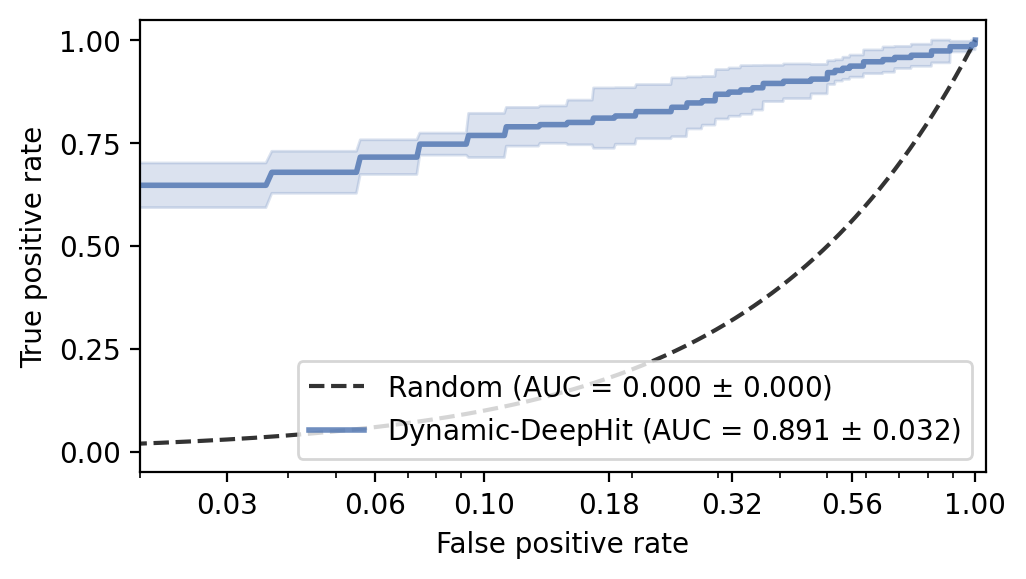

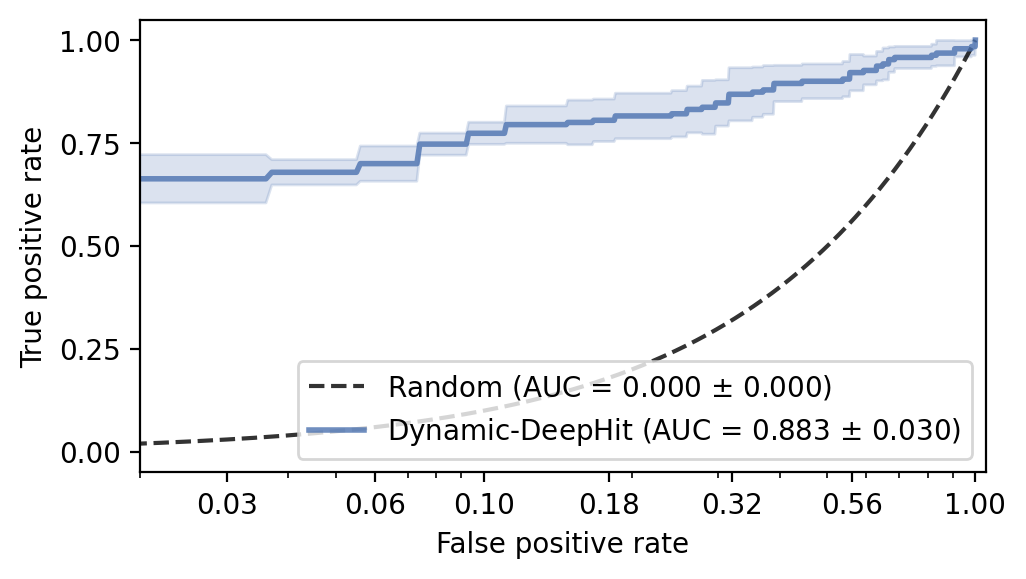

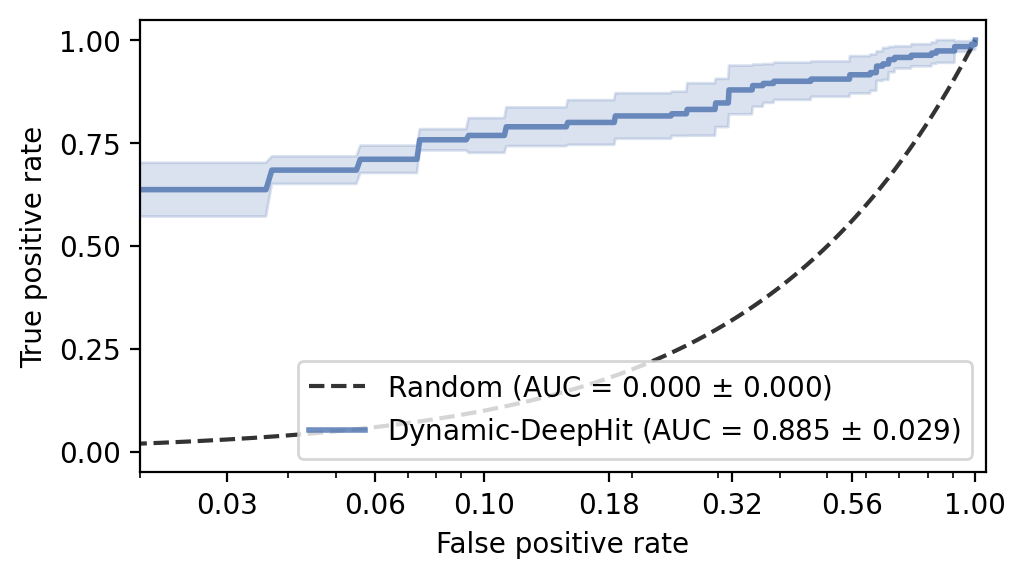

In [1046]:
from sklearn import metrics
from tqdm import tqdm

seed_list = [1234, 1111, 2222, 3333, 4444]
best_pt_path_list = ['ddh_eeg_cr3_1234_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230312_1640',
                     'ddh_eeg_cr3_1111_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230312_2338',
                     'ddh_eeg_cr3_2222_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230313_0026',
                     'ddh_eeg_cr3_3333_alpha1.0_beta0.5_gamma0.5_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230313_0021',
                     'ddh_eeg_cr3_4444_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230314_1057'
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

pred_time = list(range(1,13))
eval_time = [24, 48, 72]
mean_fpr = np.linspace(1e-10, 1, 1000)



for e, e_time in enumerate(eval_time):
    print('eval time:', e_time, end=' ')
    tprs = []
    aucs = []
    for r, seed in tqdm(enumerate(seed_list)):
        best_pt_path = best_pt_path_list[r]

        ### TRAINING-TESTING SPLIT
        (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
         tr_time_to_last,te_time_to_last,
         tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
                train_test_split(data, data_mi, time, label, time_original, time_to_last,
                                 mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

        (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
         tr_time_to_last, va_time_to_last,
         tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
                train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                                 tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

        model_name = 'ddh_eeg_cr3'
        num_Event = 3

        model = \
            DynamicDeepHitTorch(input_dim  = x_dim,
                                output_dim = num_Category,
                                layers_rnn = param['layers_rnn'],
                                hidden_rnn = param['hidden_rnn'],
                                long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                                att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                                cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                                risks      = num_Event
                               )
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
        _ = load_checkpoint(f'checkpoints/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
        model = model.to(device)

        prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            out = _f_get_pred(model, te_data, p_time, device)
            risk_death_awaken_all_future = 1 - out[:, :2, :pred_horizon].sum((1,2))

            for t, t_time in enumerate(eval_time):
                eval_horizon = int(t_time) + pred_horizon
                risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
                risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
                risk_death_old = risk_death / (risk_death+risk_awake)
                prob_death = risk_death / risk_death_awaken_all_future
                prob_awake = risk_awake / risk_death_awaken_all_future
                prob_death_all[:, p, t] = prob_death
                prob_awake_all[:, p, t] = prob_awake
                risk_death_old_all[:, p, t] = risk_death_old

        mask = (te_label==1) + (te_label==2) # for only people who died naturally, and who awoke

        scores = -(prob_awake_all / prob_death_all)[:, 5, e]
        fpr, tpr, thresholds = metrics.roc_curve(te_label[mask], scores[mask.flatten()], 
                                                 pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    n_std = 1
    scale = 'log' # {'log', 'linear'}

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, 1)
    ax.plot(mean_fpr, mean_fpr, linestyle='--', color='black', alpha=.8,
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Random', 0, 0))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Dynamic-DeepHit', mean_auc, n_std*std_auc),
            lw=2, alpha=.8)
    print(r'%s (AUC = %0.3f ± %0.3f)' % ('Dyn-DeepHit', mean_auc, n_std*std_auc))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + n_std*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std*std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2)

    plt.xlim([2e-2, 5])
    plt.yticks([0.00,0.25,0.50,0.75,1.00])
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_xticks([0.03, 0.06, 0.10, 0.18, 0.32, 0.56, 1.00])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           # title=r'Mean ROC with $\pm$ %0.1f std. dev.' % (n_std)
          )
    ax.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    auc_info = {'mean_tpr': mean_tpr, 'mean_auc': mean_auc, 'std_auc': std_auc, 'tprs': tprs}
    with open(f'ddh_auc_info_{6}_{e_time}.pickle', 'wb') as handle:
        pickle.dump(auc_info,
                    handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    fname = r'ROC_%s_%d_%d.pdf' % ('Dyn-DeepHit', 6, e_time)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
    

### hour 12

/heinz-georgenas/anaconda3/envs/py39xiaobin/lib/python3.9/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")


eval time: 24 

5it [00:01,  4.16it/s]
/tmp/ipykernel_2652409/3368646342.py:125: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


Dyn-DeepHit (AUC = 0.898 ± 0.023)


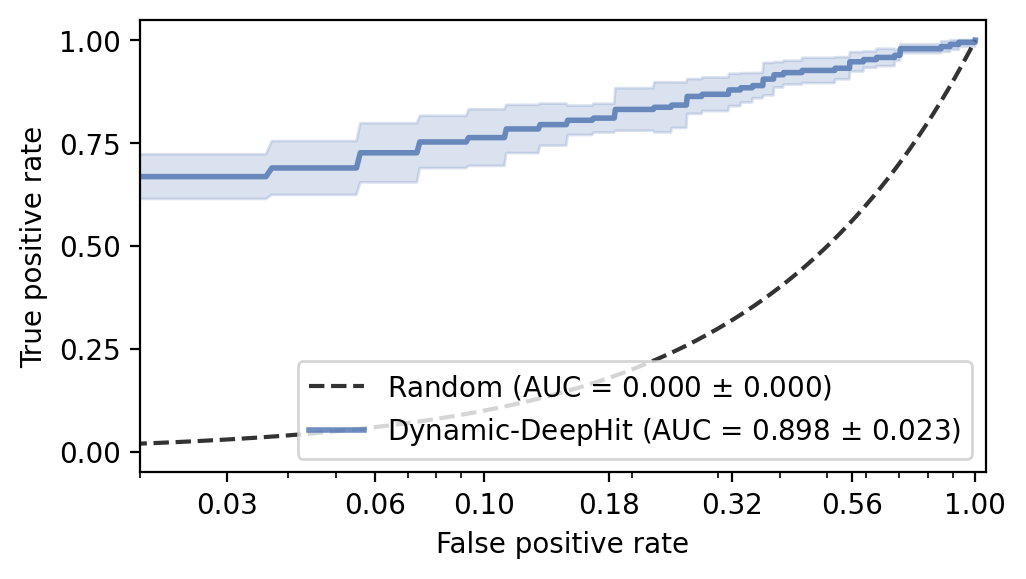

In [1048]:
from sklearn import metrics
from tqdm import tqdm

seed_list = [1234, 1111, 2222, 3333, 4444]
best_pt_path_list = ['ddh_eeg_cr3_1234_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230312_1640',
                     'ddh_eeg_cr3_1111_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230312_2338',
                     'ddh_eeg_cr3_2222_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230313_0026',
                     'ddh_eeg_cr3_3333_alpha1.0_beta0.5_gamma0.5_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230313_0021',
                     'ddh_eeg_cr3_4444_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230314_1057'
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

pred_time = list(range(1,13))
eval_time = [24, 48, 72]
mean_fpr = np.linspace(1e-10, 1, 1000)



for e, e_time in enumerate(eval_time):
    print('eval time:', e_time, end=' ')
    tprs = []
    aucs = []
    for r, seed in tqdm(enumerate(seed_list)):
        best_pt_path = best_pt_path_list[r]

        ### TRAINING-TESTING SPLIT
        (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
         tr_time_to_last,te_time_to_last,
         tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
                train_test_split(data, data_mi, time, label, time_original, time_to_last,
                                 mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

        (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
         tr_time_to_last, va_time_to_last,
         tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
                train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                                 tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

        model_name = 'ddh_eeg_cr3'
        num_Event = 3

        model = \
            DynamicDeepHitTorch(input_dim  = x_dim,
                                output_dim = num_Category,
                                layers_rnn = param['layers_rnn'],
                                hidden_rnn = param['hidden_rnn'],
                                long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                                att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                                cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                                risks      = num_Event
                               )
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
        _ = load_checkpoint(f'checkpoints/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
        model = model.to(device)

        prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            out = _f_get_pred(model, te_data, p_time, device)
            risk_death_awaken_all_future = 1 - out[:, :2, :pred_horizon].sum((1,2))

            for t, t_time in enumerate(eval_time):
                eval_horizon = int(t_time) + pred_horizon
                risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
                risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
                risk_death_old = risk_death / (risk_death+risk_awake)
                prob_death = risk_death / risk_death_awaken_all_future
                prob_awake = risk_awake / risk_death_awaken_all_future
                prob_death_all[:, p, t] = prob_death
                prob_awake_all[:, p, t] = prob_awake
                risk_death_old_all[:, p, t] = risk_death_old

        mask = (te_label==1) + (te_label==2) # for only people who died naturally, and who awoke

        scores = -(prob_awake_all / prob_death_all)[:, -1, e]
        fpr, tpr, thresholds = metrics.roc_curve(te_label[mask], scores[mask.flatten()], 
                                                 pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    n_std = 1
    scale = 'log' # {'log', 'linear'}

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, 1)
    ax.plot(mean_fpr, mean_fpr, linestyle='--', color='black', alpha=.8,
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Random', 0, 0))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Dynamic-DeepHit', mean_auc, n_std*std_auc),
            lw=2, alpha=.8)
    print(r'%s (AUC = %0.3f ± %0.3f)' % ('Dyn-DeepHit', mean_auc, n_std*std_auc))
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + n_std*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std*std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2)

    plt.xlim([2e-2, 5])
    plt.yticks([0.00,0.25,0.50,0.75,1.00])
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_xticks([0.03, 0.06, 0.10, 0.18, 0.32, 0.56, 1.00])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           # title=r'Mean ROC with $\pm$ %0.1f std. dev.' % (n_std)
          )
    ax.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    
    auc_info = {'mean_tpr': mean_tpr, 'mean_auc': mean_auc, 'std_auc': std_auc, 'tprs': tprs}
    # with open(f'ddh_auc_info_{12}_{e_time}.pickle', 'wb') as handle:
    #     pickle.dump(auc_info,
    #                 handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    fname = r'ROC_%s_%d_%d.pdf' % ('Dyn-DeepHit', 12, e_time)
    # plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
    break

In [11]:
with open(f'ddh_auc_info_{12}_{24}.pickle', 'rb') as handle:
    ddh_auc_info = pickle.load(handle)

/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")
/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
5it [00:03,  

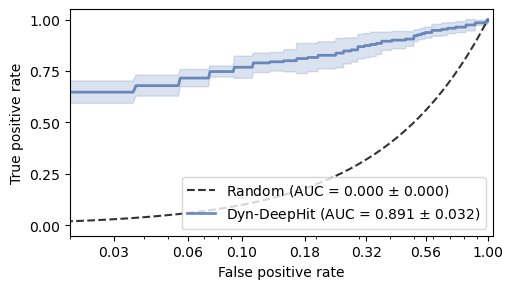

5it [00:00,  8.90it/s]
/tmp/ipykernel_95212/2475623308.py:117: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


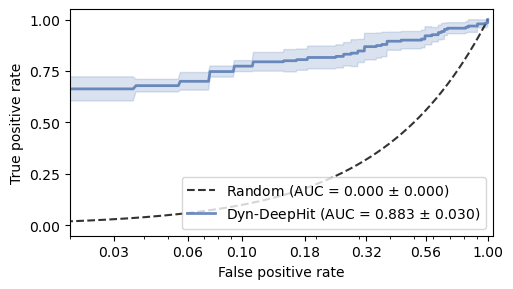

5it [00:00,  7.74it/s]
/tmp/ipykernel_95212/2475623308.py:117: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],


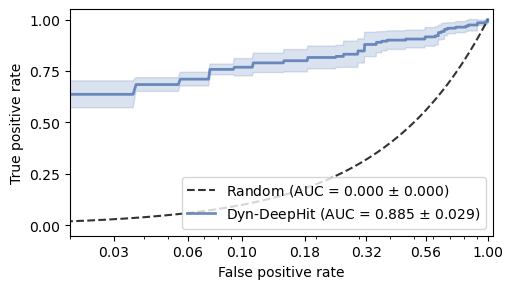

In [12]:
from sklearn import metrics
from tqdm import tqdm

seed_list = [1234, 1111, 2222, 3333, 4444]
best_pt_path_list = ['ddh_eeg_cr3_1234_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230312_1640',
                     'ddh_eeg_cr3_1111_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230312_2338',
                     'ddh_eeg_cr3_2222_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230313_0026',
                     'ddh_eeg_cr3_3333_alpha1.0_beta0.5_gamma0.5_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230313_0021',
                     'ddh_eeg_cr3_4444_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230314_1057'
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

pred_time = list(range(1,13))
eval_time = [24, 48, 72]
mean_fpr = np.linspace(1e-10, 1, 1000)

for e, e_time in enumerate(eval_time):
    tprs = []
    aucs = []
    for r, seed in tqdm(enumerate(seed_list)):
        best_pt_path = best_pt_path_list[r]

        ### TRAINING-TESTING SPLIT
        (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
         tr_time_to_last,te_time_to_last,
         tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
                train_test_split(data, data_mi, time, label, time_original, time_to_last,
                                 mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

        (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
         tr_time_to_last, va_time_to_last,
         tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
                train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                                 tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

        model_name = 'ddh_eeg_cr3'
        num_Event = 3

        model = \
            DynamicDeepHitTorch(input_dim  = x_dim,
                                output_dim = num_Category,
                                layers_rnn = param['layers_rnn'],
                                hidden_rnn = param['hidden_rnn'],
                                long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                                att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                                cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                                risks      = num_Event
                               )
        optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
        _ = load_checkpoint(f'checkpoints/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
        model = model.to(device)

        prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

        for p, p_time in enumerate(pred_time):
            pred_horizon = int(p_time)
            out = _f_get_pred(model, te_data, p_time, device)

            for t, t_time in enumerate(eval_time):
                eval_horizon = int(t_time) + pred_horizon
                risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
                risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
                prob_death = risk_death / (risk_death + risk_awake)
                prob_death_all[:, p, t] = prob_death

        mask = (te_label==1) + (te_label==2) # for only people who died naturally, and who awoke

        scores = prob_death_all[:, 5, e]
        fpr, tpr, thresholds = metrics.roc_curve(te_label[mask], scores[mask.flatten()], 
                                                 pos_label=1)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    n_std = 1
    scale = 'log' # {'log', 'linear'}

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(3, 2, 1)
    ax.plot(mean_fpr, mean_fpr, linestyle='--', color='black', alpha=.8,
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Random', 0, 0))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'%s (AUC = %0.3f $\pm$ %0.3f)' % ('Dyn-DeepHit', mean_auc, n_std*std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + n_std*std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - n_std*std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='b', alpha=.2)

    plt.xlim([2e-2, 5])
    plt.yticks([0.00,0.25,0.50,0.75,1.00])
    if scale == 'log':
        ax.set_xscale(scale)
        ax.set_xticks([0.03, 0.06, 0.10, 0.18, 0.32, 0.56, 1.00])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           # title=r'Mean ROC with $\pm$ %0.1f std. dev.' % (n_std)
          )
    ax.legend(loc='lower right')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

# Part III: Test the model

In [957]:
risk_all.keys()

dict_keys([0, 1, 2])

In [13]:
def eval_model(model, te_data, pred_time, eval_time, num_Event, te_time, device='cuda', te_label_cp=None, mask=False):
    # pred_time = [4, 8, 12]
    # eval_time = [12, 24, 36, 48, 60, 72]
    
    if te_label_cp is None:
        te_label_cp = te_label
        
    risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device=device)

    for p, p_time in enumerate(pred_time):
        pred_horizon = int(p_time)
        
        if mask:
            mask_longer_than_p_time = (te_data.sum(2) != 0).sum(1) >= p_time
            print('\tnum after mask:', mask_longer_than_p_time.sum())
            for k in range(num_Event):
                risk_all[k] = risk_all[k][mask_longer_than_p_time]
            te_data = te_data[mask_longer_than_p_time]
            te_label_cp = te_label_cp[mask_longer_than_p_time]
            te_time = te_time[mask_longer_than_p_time]
        
        result1, result2 = np.zeros([num_Event, len(eval_time)]), np.zeros([num_Event, len(eval_time)])

        for t, t_time in enumerate(eval_time):                
            eval_horizon = int(t_time) + pred_horizon
            for k in range(num_Event):
                result1[k, t] = c_index(risk_all[k][:, p, t], te_time, (te_label_cp[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                result2[k, t] = brier_score(risk_all[k][:, p, t], te_time, (te_label_cp[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)

        if p == 0:
            final1, final2 = result1, result2
        else:
            final1, final2 = np.append(final1, result1, axis=0), np.append(final2, result2, axis=0)


    row_header = []
    for p_time in pred_time:
        for k in range(num_Event):
            row_header.append('pred_time {}: event_{}'.format(p_time, k+1))

    col_header = []
    for t_time in eval_time:
        col_header.append('eval_time {}'.format(t_time))

    # c-index result
    df1 = pd.DataFrame(final1, index = row_header, columns=col_header)

    # brier-score result
    df2 = pd.DataFrame(final2, index = row_header, columns=col_header)

    ### PRINT RESULTS
    print('========================================================')
    print('--------------------------------------------------------')
    print('- C-INDEX: ')
    print(df1)
    print('--------------------------------------------------------')
    print('- BRIER-SCORE: ')
    print(df2)
    print('========================================================')
    
    return df1, df2

## three competing risk
- 1: Death (Rearrested, intractable shock, multisystem organ failure; Brain death)
- 2: Awake
- 3: Withdrawal for perceived poor neurological prognosis

In [14]:
seed = SEED

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr4']

if data_mode == 'EEG_nocr':
    path = '../../eeg/varying-seq-len/EEG_processed_data_long.csv'
elif data_mode == 'EEG_cr2':
    path = '../../eeg/competing-risk/EEG_processed_data_long.csv'
elif data_mode == 'EEG_cr4':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat.csv'
elif data_mode == 'EEG_cr3':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]

### TRAINING-TESTING SPLIT
(tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
 tr_time_to_last,te_time_to_last,
 tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
        train_test_split(data, data_mi, time, label, time_original, time_to_last,
                         mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

(tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
 tr_time_to_last, va_time_to_last,
 tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
        train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                         tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

num_Event

/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")
/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


3

In [15]:
from collections import Counter
Counter(label.flatten())

Counter({1.0: 189, 2.0: 271, 3.0: 432, 0.0: 30})

In [16]:
pred_time = [6,12]
eval_time = [24, 48, 72, 96]
model_name = 'ddh_eeg_cr3'
num_Event = 3

best_pt_path = 'ddh_eeg_cr3_1234_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230312_1640'
# best_pt_path = 'ddh_eeg_cr3_1111_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230312_2338'
# best_pt_path = 'ddh_eeg_cr3_2222_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230313_0026'
# best_pt_path = 'ddh_eeg_cr3_3333_alpha1.0_beta0.5_gamma0.5_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230313_0021'
# best_pt_path = 'ddh_eeg_cr3_4444_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230314_1057'
model = \
    DynamicDeepHitTorch(input_dim  = x_dim,
                        output_dim = num_Category,
                        layers_rnn = param['layers_rnn'],
                        hidden_rnn = param['hidden_rnn'],
                        long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                        att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                        cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                        risks      = num_Event
                       )
optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
_ = load_checkpoint(f'checkpoints/{model_name}/{best_pt_path}_{SEED}.pt', model, optimizer, device)
model = model.to(device)

df1, df2 = eval_model(model, te_data, pred_time, eval_time, num_Event, te_time_original)

--------------------------------------------------------
- C-INDEX: 
                       eval_time 24  eval_time 48  eval_time 72  eval_time 96
pred_time 6: event_1       0.797718      0.739404      0.751018      0.732949
pred_time 6: event_2       0.860689      0.863852      0.869906      0.880426
pred_time 6: event_3       0.726845      0.623837      0.646253      0.621651
pred_time 12: event_1      0.776279      0.741982      0.751737      0.755991
pred_time 12: event_2      0.866443      0.864875      0.869504      0.874852
pred_time 12: event_3      0.772701      0.644598      0.681873      0.674831
--------------------------------------------------------
- BRIER-SCORE: 
                       eval_time 24  eval_time 48  eval_time 72  eval_time 96
pred_time 6: event_1       0.038417      0.076800      0.104254      0.116450
pred_time 6: event_2       0.049891      0.089746      0.108345      0.112672
pred_time 6: event_3       0.088959      0.159892      0.196840      0.200495


### avg c-index

In [17]:
pred_time = [6,12]
eval_time = [24, 48, 72]

seed_list = [1234, 1111, 2222, 3333, 4444]

best_pt_path_list = ['ddh_eeg_cr3_1234_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230312_1640'
                    ,'ddh_eeg_cr3_1111_alpha1.0_beta0.5_gamma0.1_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230312_2338'
                    ,'ddh_eeg_cr3_2222_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230313_0026'
                    ,'ddh_eeg_cr3_3333_alpha1.0_beta0.5_gamma0.5_BSZ32_Lr0.0005_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.2_20230313_0021'
                    ,'ddh_eeg_cr3_4444_alpha1.0_beta0.5_gamma0.05_BSZ32_Lr0.001_hiddenRNN64_hiddenFC64_layersRNN2_hiddenAtt2_hiddenCS2_dropout0.4_20230314_1057'
                    ]

data_mode = 'EEG_cr3' # ['EEG_nocr', 'EEG_cr2', 'EEG_cr3', 'EEG_cr4']

if data_mode == 'EEG_nocr':
    path = '../../eeg/competing-risk/EEG_processed_data_long_by_death_cat_exclude_3.csv'

(x_dim, x_dim_cont, x_dim_bin), (data, time, label, time_original, time_to_last), \
    (mask1, mask2, mask3), (data_mi), trans_discrete_time = \
                impt.import_dataset(path)

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask3: [subj, Num_Event, Num_Category]
max_length                  = np.shape(data)[1]


C_INDEX = []

for r, seed in tqdm(enumerate(seed_list)):
    best_pt_path = best_pt_path_list[r]

    ### TRAINING-TESTING SPLIT
    (tr_data,te_data, tr_data_mi, te_data_mi, tr_time,te_time, tr_label,te_label, tr_time_orinal,te_time_original,
     tr_time_to_last,te_time_to_last,
     tr_mask1,te_mask1, tr_mask2,te_mask2, tr_mask3,te_mask3) = \
            train_test_split(data, data_mi, time, label, time_original, time_to_last,
                             mask1, mask2, mask3, test_size=0.2, stratify=label, random_state=seed) 

    (tr_data,va_data, tr_data_mi, va_data_mi, tr_time,va_time, tr_label,va_label, tr_time_orinal,va_time_original,
     tr_time_to_last, va_time_to_last,
     tr_mask1,va_mask1, tr_mask2,va_mask2, tr_mask3,va_mask3) = \
            train_test_split(tr_data, tr_data_mi, tr_time, tr_label, tr_time_orinal, tr_time_to_last,
                             tr_mask1, tr_mask2, tr_mask3, test_size=0.2, stratify=tr_label, random_state=seed) 

    model_name = 'ddh_eeg_cr3'
    num_Event = 3

    model = \
        DynamicDeepHitTorch(input_dim  = x_dim,
                            output_dim = num_Category,
                            layers_rnn = param['layers_rnn'],
                            hidden_rnn = param['hidden_rnn'],
                            long_param = {'layers': 2*[param['hidden_dim_FC']], 'dropout': dropout}, 
                            att_param  = {'layers': param['hidden_att']*[param['hidden_dim_FC']], 'dropout': dropout}, 
                            cs_param   = {'layers': param['hidden_cs']*[param['hidden_dim_FC']], 'dropout': dropout},
                            risks      = num_Event
                           )
    optimizer = torch.optim.Adam(model.parameters(), lr = lr_train)
    _ = load_checkpoint(f'checkpoints/{model_name}/{best_pt_path}_{seed}.pt', model, optimizer, device)
    model = model.to(device)
    
    df1, df2 = eval_model(model, te_data, pred_time, eval_time, num_Event, te_time_original, mask=True)
    C_INDEX.append(df1)

/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/pycox/preprocessing/label_transforms.py:113: UserWarning: Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.
  warnings.warn("Calling fit method, when 'cuts' are already defined. Leaving cuts unchanged.")
/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/heinz-georgenas/anaconda3/envs/py38xiaobin/lib/python3.8/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
1it [00:00,  

	num after mask: 164
	num after mask: 137
--------------------------------------------------------
- C-INDEX: 
                       eval_time 24  eval_time 48  eval_time 72
pred_time 6: event_1       0.810307      0.747373      0.751890
pred_time 6: event_2       0.847314      0.860618      0.866966
pred_time 6: event_3       0.573192      0.599897      0.631827
pred_time 12: event_1      0.916828      0.773547      0.778656
pred_time 12: event_2      0.870280      0.868681      0.872313
pred_time 12: event_3      0.660000      0.632400      0.698080
--------------------------------------------------------
- BRIER-SCORE: 
                       eval_time 24  eval_time 48  eval_time 72
pred_time 6: event_1       0.029492      0.068625      0.096443
pred_time 6: event_2       0.045207      0.091461      0.111808
pred_time 6: event_3       0.072328      0.151123      0.191381
pred_time 12: event_1      0.021542      0.054819      0.071784
pred_time 12: event_2      0.049225      0.10145

3it [00:00,  7.29it/s]

--------------------------------------------------------
- C-INDEX: 
                       eval_time 24  eval_time 48  eval_time 72
pred_time 6: event_1       0.682959      0.588460      0.632821
pred_time 6: event_2       0.860542      0.868810      0.864198
pred_time 6: event_3       0.853052      0.712156      0.662594
pred_time 12: event_1      0.764948      0.663169      0.684507
pred_time 12: event_2      0.854673      0.865586      0.863465
pred_time 12: event_3      0.755319      0.696690      0.702364
--------------------------------------------------------
- BRIER-SCORE: 
                       eval_time 24  eval_time 48  eval_time 72
pred_time 6: event_1       0.035412      0.073610      0.104444
pred_time 6: event_2       0.049125      0.089489      0.113020
pred_time 6: event_3       0.084071      0.166526      0.214708
pred_time 12: event_1      0.029425      0.064279      0.092991
pred_time 12: event_2      0.051847      0.096639      0.123283
pred_time 12: event_3     

5it [00:00,  7.35it/s]

	num after mask: 138
--------------------------------------------------------
- C-INDEX: 
                       eval_time 24  eval_time 48  eval_time 72
pred_time 6: event_1       0.529489      0.679043      0.615091
pred_time 6: event_2       0.856127      0.855092      0.842417
pred_time 6: event_3       0.854419      0.620643      0.587037
pred_time 12: event_1      0.442536      0.629450      0.649343
pred_time 12: event_2      0.816381      0.843859      0.843659
pred_time 12: event_3      0.752039      0.654250      0.651238
--------------------------------------------------------
- BRIER-SCORE: 
                       eval_time 24  eval_time 48  eval_time 72
pred_time 6: event_1       0.024013      0.067623      0.099276
pred_time 6: event_2       0.035177      0.088776      0.114245
pred_time 6: event_3       0.059682      0.158315      0.196596
pred_time 12: event_1      0.035469      0.077559      0.108576
pred_time 12: event_2      0.047932      0.094281      0.119370
pred_

In [18]:
c_index_mean = np.zeros_like(C_INDEX[0].values)
c_index_std = np.zeros_like(C_INDEX[0].values)
for i in range(c_index_mean.shape[0]):
    for j in range(c_index_mean.shape[1]):
        c_list = [C_INDEX[k].iloc[i,j] for k in range(len(seed_list))]
        c_list = np.array(c_list)
        c_index_mean[i,j] = c_list.mean()
        c_index_std[i,j]  = c_list.std()
        
C_index_mean = C_INDEX[0].copy()
C_index_std = C_INDEX[0].copy()
C_index_mean.iloc[:, :] = c_index_mean
C_index_std.iloc[:, :] = c_index_std

In [19]:
C_index_mean[::3]

,eval_time 24,eval_time 48,eval_time 72
pred_time 6: event_1,0.692544,0.709770,0.706578
pred_time 12: event_1,0.722601,0.693602,0.714972


In [20]:
C_index_mean[1::3]

,eval_time 24,eval_time 48,eval_time 72
pred_time 6: event_2,0.851892,0.868930,0.864377
pred_time 12: event_2,0.840182,0.856754,0.855416


In [21]:
C_index_mean[2::3]

,eval_time 24,eval_time 48,eval_time 72
pred_time 6: event_3,0.744455,0.605611,0.619357
pred_time 12: event_3,0.711382,0.643909,0.684655


In [22]:
C_index_std

,eval_time 24,eval_time 48,eval_time 72
pred_time 6: event_1,0.091992,0.068740,0.068556
pred_time 6: event_2,0.006859,0.010433,0.014369
pred_time 6: event_3,0.105867,0.061550,0.025893
pred_time 12: event_1,0.216627,0.051631,0.050094
pred_time 12: event_2,0.040671,0.019784,0.021493
pred_time 12: event_3,0.036833,0.029698,0.018146


### binary class performance

In [23]:
pred_time = list(range(1,13))
eval_time = [24, 48, 72]

prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
prob_awake_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
risk_death_old_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
for p, p_time in enumerate(pred_time):
    pred_horizon = int(p_time)
    out = _f_get_pred(model, te_data, p_time, device)
    risk_death_awaken_all_future = 1 - out[:, :2, :pred_horizon].sum((1,2))
    
    for t, t_time in enumerate(eval_time):
        eval_horizon = int(t_time) + pred_horizon
        risk_death = out[:, 0, pred_horizon:eval_horizon+1].sum(1)
        risk_awake = out[:, 1, pred_horizon:eval_horizon+1].sum(1)
        risk_death_old = risk_death / (risk_death+risk_awake)
        prob_death = risk_death / risk_death_awaken_all_future
        prob_awake = risk_awake / risk_death_awaken_all_future
        prob_death_all[:, p, t] = prob_death
        prob_awake_all[:, p, t] = prob_awake
        risk_death_old_all[:, p, t] = risk_death_old

In [39]:
prob_death_all.min(), prob_death_all.max()

(9.326387978068104e-28, 0.23102495074272156)

0.08428256586194038 0.23102495074272156


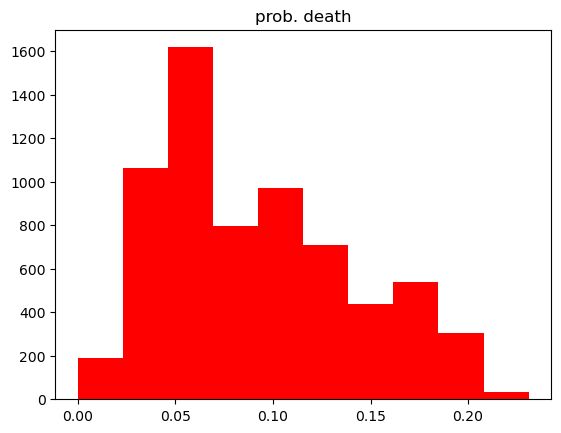

In [24]:
print(np.median(prob_death_all.flatten()), prob_death_all.max() )
plt.hist(prob_death_all.flatten(), color='red')
plt.title('prob. death')
plt.show()

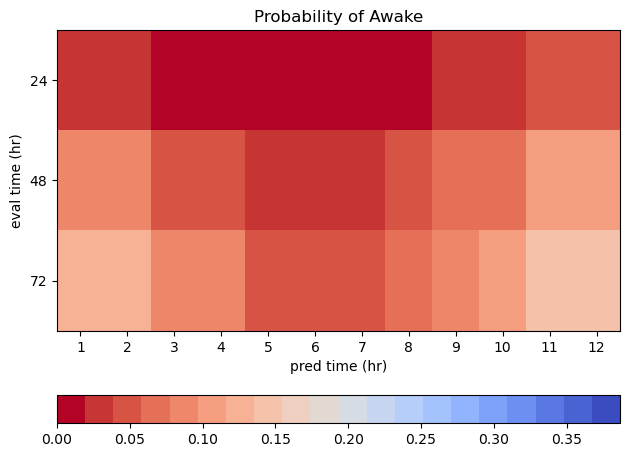

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom color map with 10 shades of red
colors = plt.cm.coolwarm_r(np.linspace(0, 1, 20))  # Generate 10 shades of red
cmap_awake = plt.cm.colors.ListedColormap(colors)  # Create custom color map
norm_awake = plt.Normalize(prob_awake_all.flatten().min(), prob_awake_all.flatten().max())  # Normalize data

i = 173

# Create heatmap with custom color map
fig, ax = plt.subplots()
im = ax.imshow(prob_awake_all[i].T, cmap=cmap_awake, norm=norm_awake, aspect='auto')

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax,orientation = 'horizontal')
# cbar.ax.set_ylabel('Value', rotation=-90, va="bottom")
plt.title('Probability of Awake')
plt.yticks(np.arange(3), [ 24, 48, 72])
plt.xticks(np.arange(12), list(range(1,13)))
plt.ylabel('eval time (hr)', fontsize=10)
plt.xlabel('pred time (hr)', fontsize=10)
# plt.subplots_adjust(bottom=-0.5)
plt.tight_layout()

# Show the plot
plt.show()


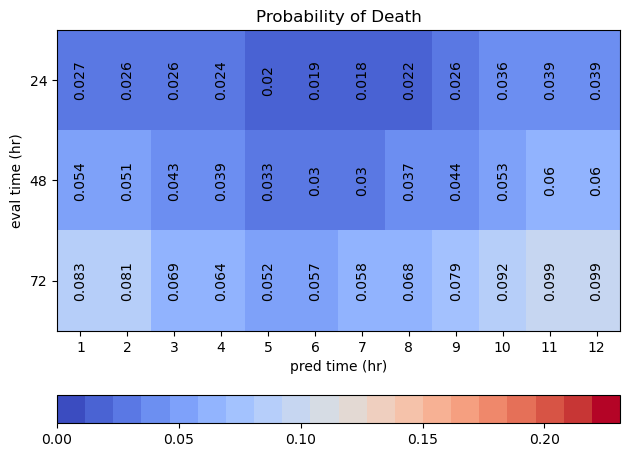

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define custom color map with 10 shades of red
colors = plt.cm.coolwarm(np.linspace(0, 1, 20))  # Generate 10 shades of red
cmap_death = plt.cm.colors.ListedColormap(colors)  # Create custom color map

# # Define custom color map with 10 shades of blue for lowest values and 10 shades of red for highest values
# blues = plt.cm.Blues(np.linspace(0.9, 0.1, 10))  # Generate 10 shades of blue
# reds = plt.cm.Reds(np.linspace(0.1, 0.8, 10))  # Generate 10 shades of red
# colors = np.vstack((blues, reds))  # Stack blue and red colors
# cmap = plt.cm.colors.ListedColormap(colors)  # Create custom color map

norm_death = plt.Normalize(prob_death_all.flatten().min(), prob_death_all.flatten().max())  # Normalize data

i = 173

# Create heatmap with custom color map
fig, ax = plt.subplots()
im = ax.imshow(prob_death_all[i].T, cmap=cmap_death, norm=norm_death, aspect='auto')

# Add color bar
cbar = ax.figure.colorbar(im, ax=ax, orientation='horizontal')

# add probability values to each cell
for j in range(prob_death_all[i].shape[0]): #12
    for k in range(prob_death_all[i].shape[1]): #3
        text = ax.text(j, k, round(prob_death_all[i][j,k], 3), ha='center', va='center', color='black', fontsize=10, rotation='vertical')
        
# cbar.ax.set_ylabel('Value', rotation=-90, va="bottom")
plt.title('Probability of Death')
plt.yticks(np.arange(3), [ 24, 48, 72])
plt.xticks(np.arange(12), list(range(1,13)))
plt.ylabel('eval time (hr)', fontsize=10)
plt.xlabel('pred time (hr)', fontsize=10)
# plt.subplots_adjust(bottom=-0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [27]:
mask = (te_label==1) + (te_label==2)
te_label[mask]

array([2., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 2.,
       2., 2., 2., 2., 1., 2., 2., 1., 1., 1., 1., 2., 2., 2., 1., 2., 1.,
       2., 1., 2., 2., 2., 1., 2., 2., 1., 1., 1., 2., 2., 2., 1., 1., 1.,
       2., 2., 2., 2., 1., 2., 1., 1., 1., 1., 1., 2., 2., 1., 2., 2., 1.,
       2., 1., 1., 2., 1., 1., 2., 1., 2., 2., 1., 1., 1., 1., 1., 1., 2.,
       2., 1., 2., 2., 2., 2., 2.])

In [28]:
label_death = 1 * (te_label.flatten() == 1)
target_names = ['awake', 'death']
print(classification_report(label_death[mask.flatten()], 
                            1*(scores>0.5)[mask.flatten()], 
                            target_names=target_names,
                            digits=4))

print('specificity of bad outcome is the recall of awake')

NameError: name 'classification_report' is not defined

In [29]:
label_death[mask.flatten()]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0])

### single event KM curve

In [30]:
out_awake = out[:, 1, :] / out[:, 1, :].sum(1, keepdims=True)
# pred_surv_awake = 1 - out_awake.cumsum(1) # # probability of still-in-coma curve

In [31]:
pred_surv_awake = 1 - out[:, 1, :].cumsum(1)
pred_surv_death = 1 - out[:, 0, :].cumsum(1)
pred_surv_withdraw = 1 - out[:, 2, :].cumsum(1)

In [32]:
pred_surv_awake.shape

(185, 120)

### individual visualization

In [33]:
colors = ['red', 'blue', 'orange', 'black']

patient 173 time: 114.0 label: 1.0 death (not W-LST)
patient 74 time: 106.0 label: 2.0 awaken
patient 33 time: 46.0 label: 2.0 awaken
patient 45 time: 95.0 label: 3.0 W-LST
patient 177 time: 101.0 label: 1.0 death (not W-LST)


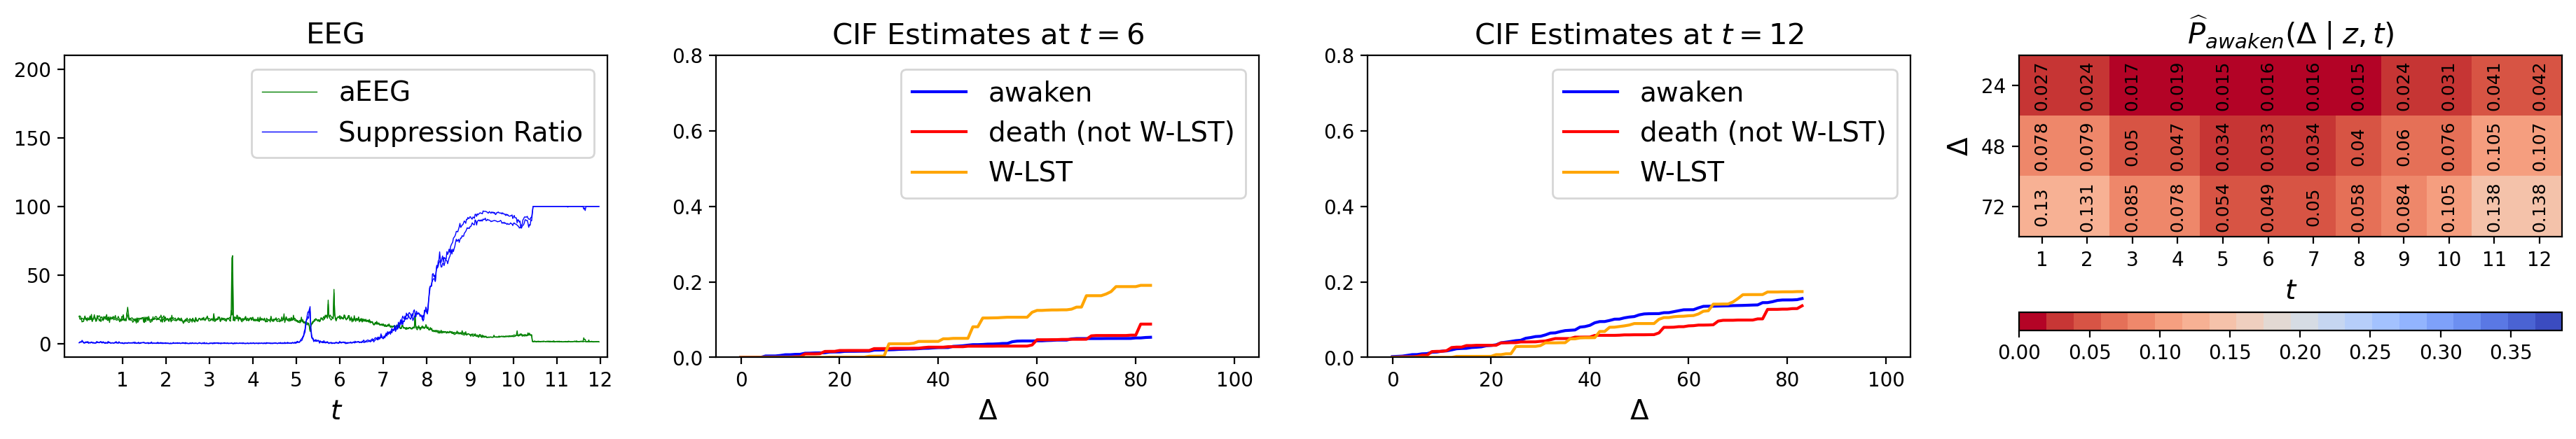

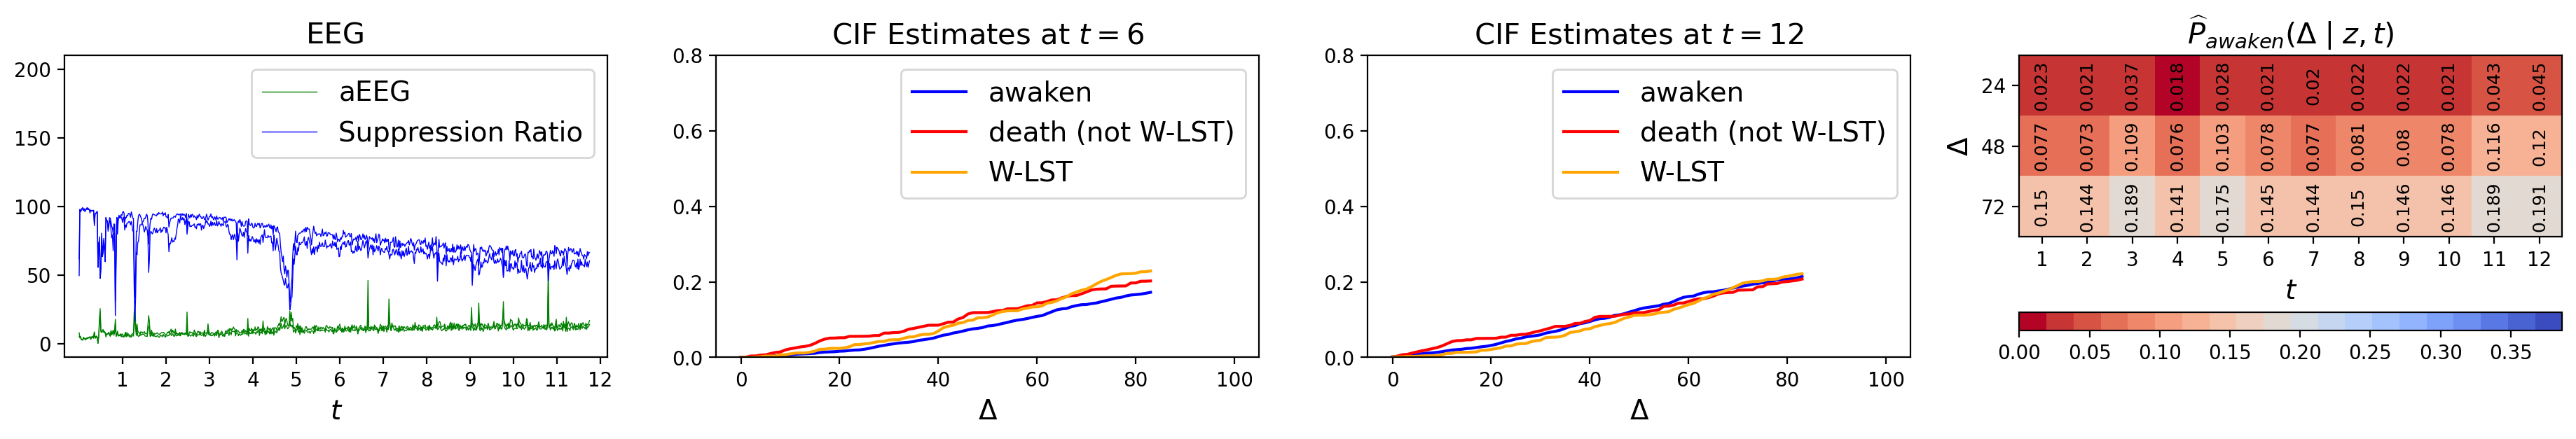

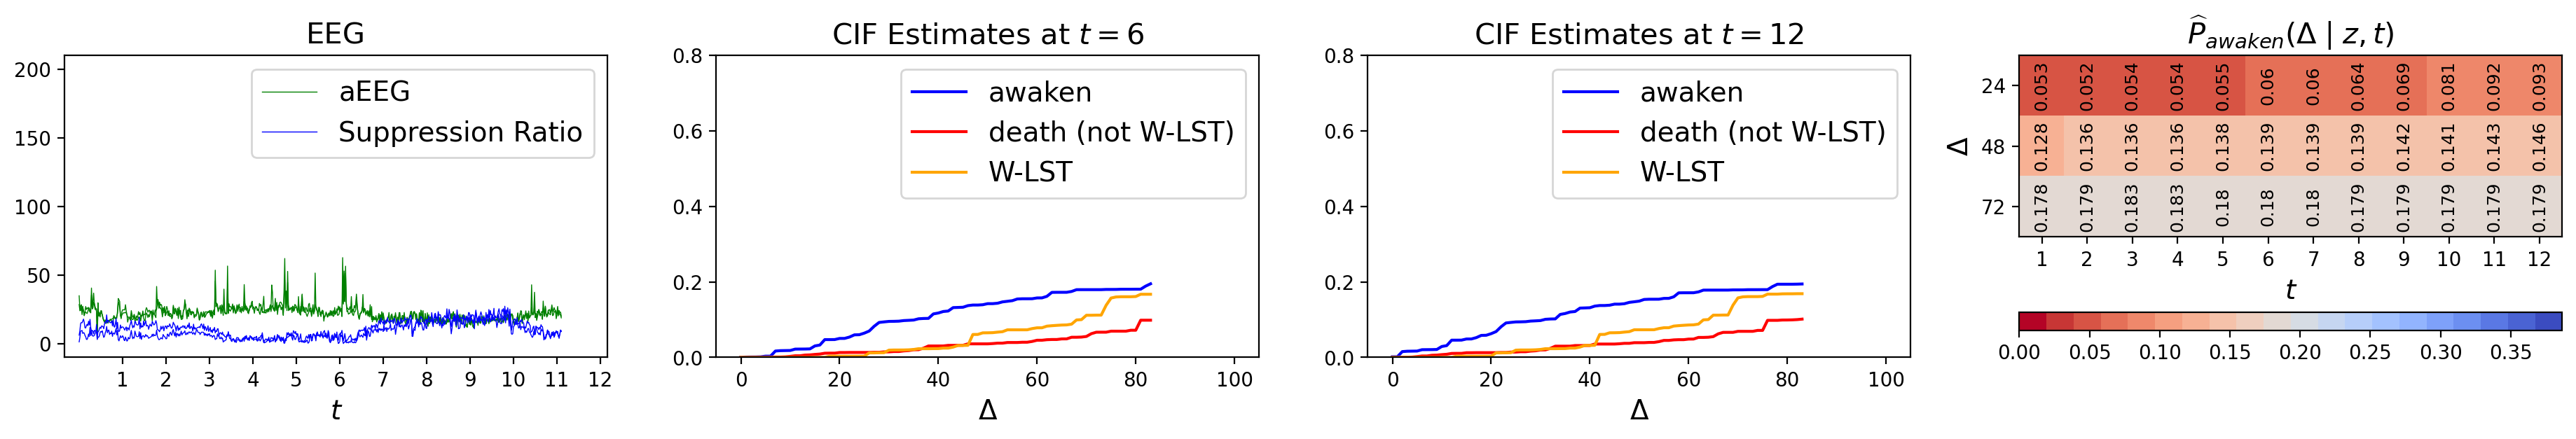

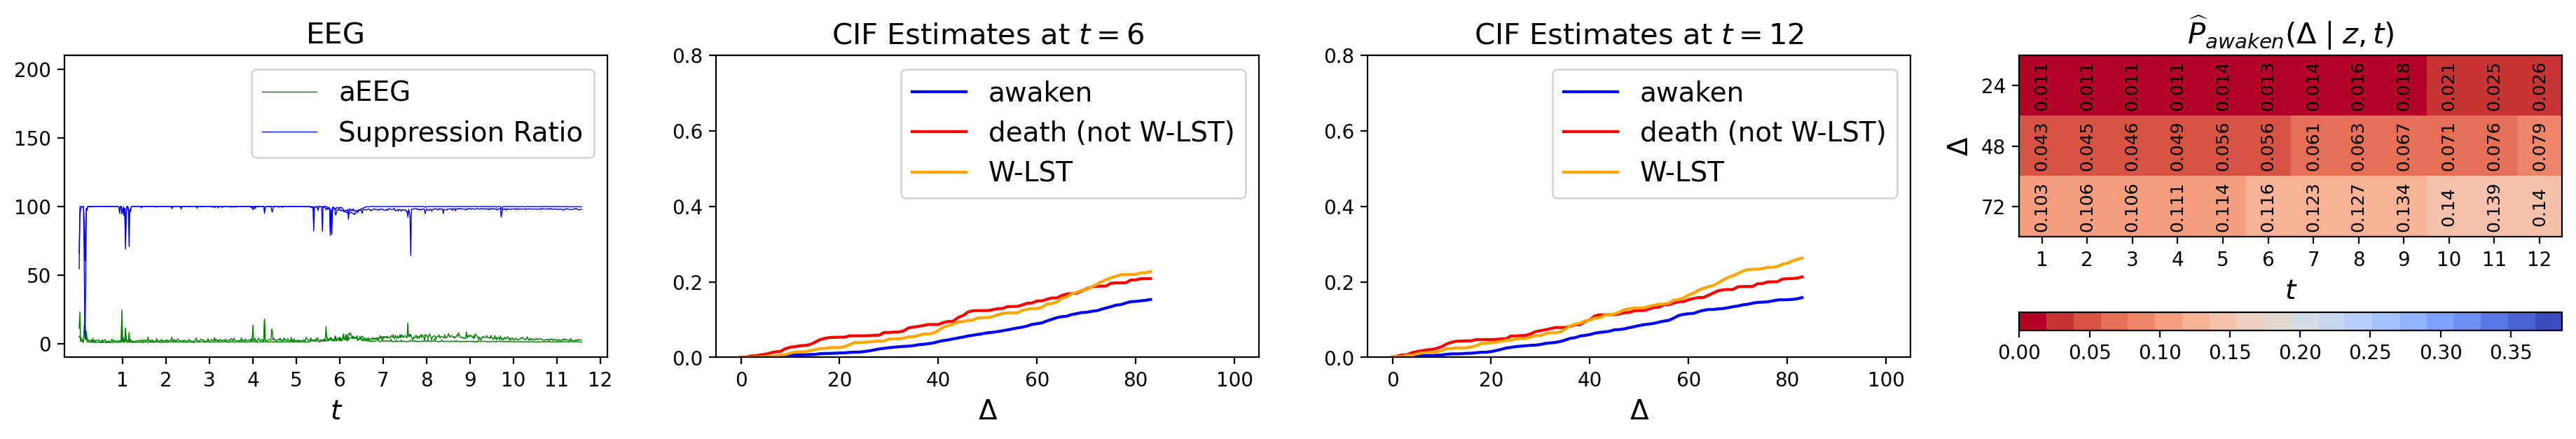

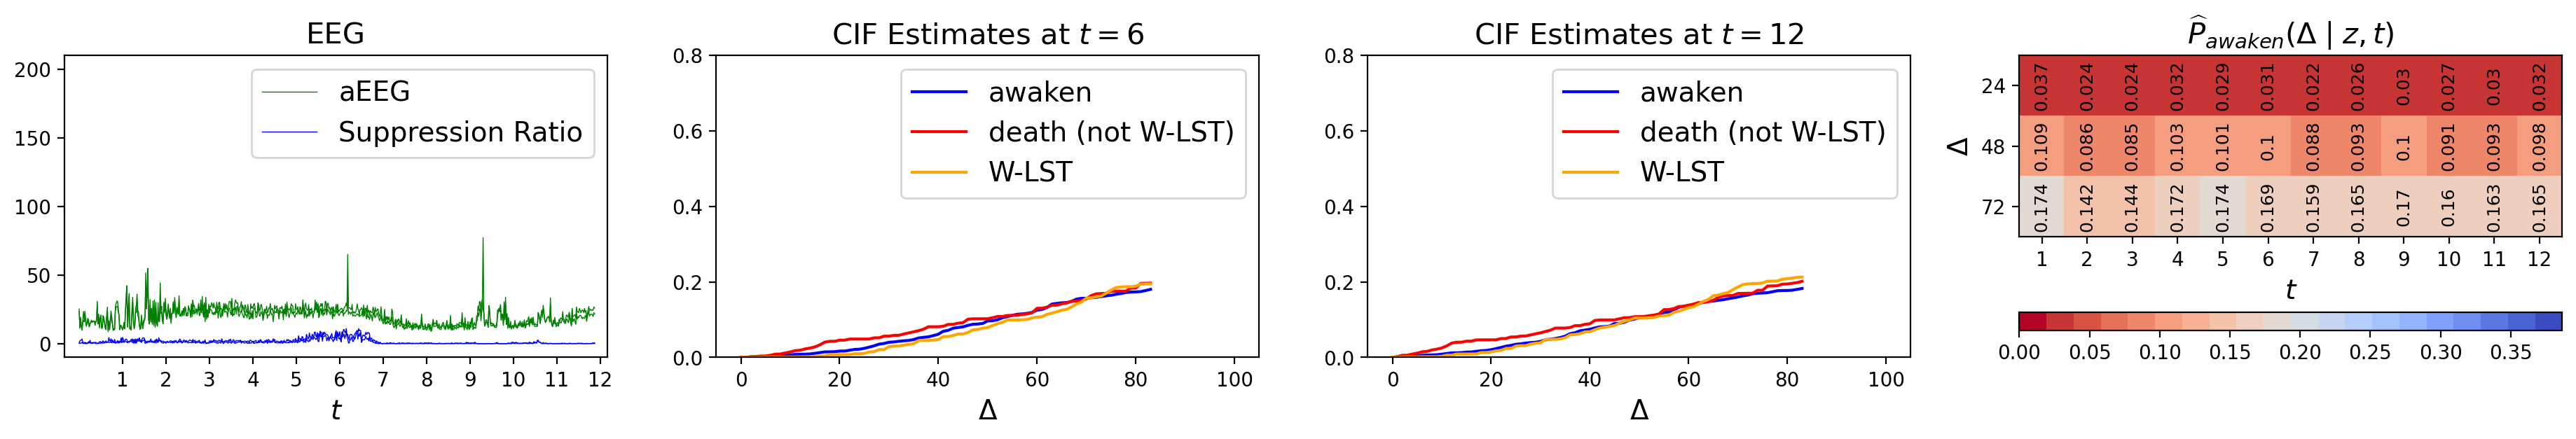

In [34]:
import matplotlib.pyplot as plt
plt.style.use('default')
%config InlineBackend.figure_format = 'retina'

pred_time = list(range(1,13))
eval_time = list(range(0,84))
risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device)
# d = {0: 'censor', 1: 'death', 2: 'awake', 3: 'withdrawal'}
d = {0: 'censor', 1: 'death (not W-LST)', 2: 'awaken', 3: 'W-LST'}

linewidth = 0.5
title_fontsize = 15
label_fontsize = 14

for ii, i in enumerate([173, 74, 33, 45, 177]): 
    print('patient', i, 'time:', te_time[i][0], 'label:', te_label[i][0], d[te_label[i][0]])
    # print('rmean event time (hr) - death: {:.1f}, awake: {:.1f}, withdrawal: {:.1f}'.format(
    #                     rmean_surv_time_death[i], rmean_surv_time_awake[i], rmean_surv_time_withdraw[i]))
    fig = plt.figure(figsize=(23,2.8))
    
    ax = fig.add_subplot(141)
    curr_X = te_all_eeg[i]
    plt.ylim(-10,210)
    plt.xlim(-20, 730)
    # dim = np.arange(1,13,1)
    # plt.xticks(np.arange(len(dim)), np.arange(1,len(dim)+1))
    plt.plot(curr_X[:, 4], c='green', linewidth=linewidth, label='aEEG') ## left aEEG median 
    plt.plot(curr_X[:, 9], c='green', linewidth=linewidth) ## right aEEG median
    plt.plot(curr_X[:, 0], c='blue', linewidth=linewidth, label='Suppression Ratio') ## left Suppression Ratio
    plt.plot(curr_X[:, 1], c='blue', linewidth=linewidth) ## left Suppression Ratio
    plt.xlabel(r'$t$', fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)
    plt.title('EEG', fontsize=title_fontsize)
    plt.xticks(np.arange(60, 721, 60), list(range(1,13)))
    
    ax = fig.add_subplot(142)
    # plt.figure(figsize=(4,2))
    event = 2
    plt.plot(list(range(84)), risk_all[event-1][i][6], c='blue', label=d[event]) #plt.plot(list(range(6, 6+84)), risk_all[event-1][i][6], c='blue', label=d[event])
    event = 1
    plt.plot(list(range(84)), risk_all[event-1][i][6], c='red', label=d[event])
    event = 3
    plt.plot(list(range(84)), risk_all[event-1][i][6], c='orange', label=d[event])
    plt.legend(fontsize=label_fontsize)
    plt.ylim(0,0.8)
    plt.xlim(-5, 105)
    plt.xlabel(r'$\Delta$', fontsize=label_fontsize)
    plt.title(r'CIF Estimates at $t=6$', fontsize=title_fontsize)
    #plt.show()
    
    ax = fig.add_subplot(143)
    # plt.figure(figsize=(4,2))
    event = 2
    plt.plot(list(range(84)), risk_all[event-1][i][-1], c='blue', label=d[event])# plt.plot(list(range(12, 96)), risk_all[event-1][i][-1], c='blue', label=d[event])
    event = 1
    plt.plot(list(range(84)), risk_all[event-1][i][-1], c='red', label=d[event])
    event = 3
    plt.plot(list(range(84)), risk_all[event-1][i][-1], c='orange', label=d[event])
    plt.legend(fontsize=label_fontsize)
    plt.ylim(0,0.8)
    plt.xlim(-5, 105)
    plt.xlabel(r'$\Delta$', fontsize=label_fontsize)
    plt.title(r'CIF Estimates at $t=12$', fontsize=title_fontsize)
    
    
    
    ax = fig.add_subplot(144)
    im = ax.imshow(prob_awake_all[i].T, cmap=cmap_awake, norm=norm_awake, aspect='auto')
    # Add color bar
    cbar = ax.figure.colorbar(im, ax=ax,orientation = 'horizontal', pad=0.25, aspect=30)
    for j in range(prob_awake_all[i].shape[0]): #12
        for k in range(prob_awake_all[i].shape[1]): #3
            text = ax.text(j, k, round(prob_awake_all[i][j,k], 3), ha='center', va='center', color='black', fontsize=9, rotation='vertical')
    # cbar.ax.set_ylabel('Value', rotation=-90, va="bottom")
    plt.title(r'$\widehat{P}_{awaken}(\Delta \mid z, t)$', fontsize=title_fontsize)
    # plt.title(r'$\widehat{P}_{\text{awaken}}(\Delta \mid z, t)$', fontsize=title_fontsize)
    
    plt.yticks(np.arange(3), [ 24, 48, 72])
    plt.xticks(np.arange(12), list(range(1,13)))
    plt.ylabel(r'$\Delta$', fontsize=label_fontsize)
    plt.xlabel(r'$t$', fontsize=label_fontsize)
    
    
    
    
    fname = 'ddh_1234_test_visual_new/patient{:}-time_{:}-label_{:}_{:}.pdf'.\
                        format(i, te_time[i][0], te_label[i][0], d[te_label[i][0]] )
    fname = 'ddh_1234_test_visual_new/p{}-visual2-poster.pdf'.format(ii+1)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()

patient 50 time: 21.0 label: 2.0 awake
patient 135 time: 51.0 label: 2.0 awake
patient 141 time: 53.0 label: 3.0 withdrawal


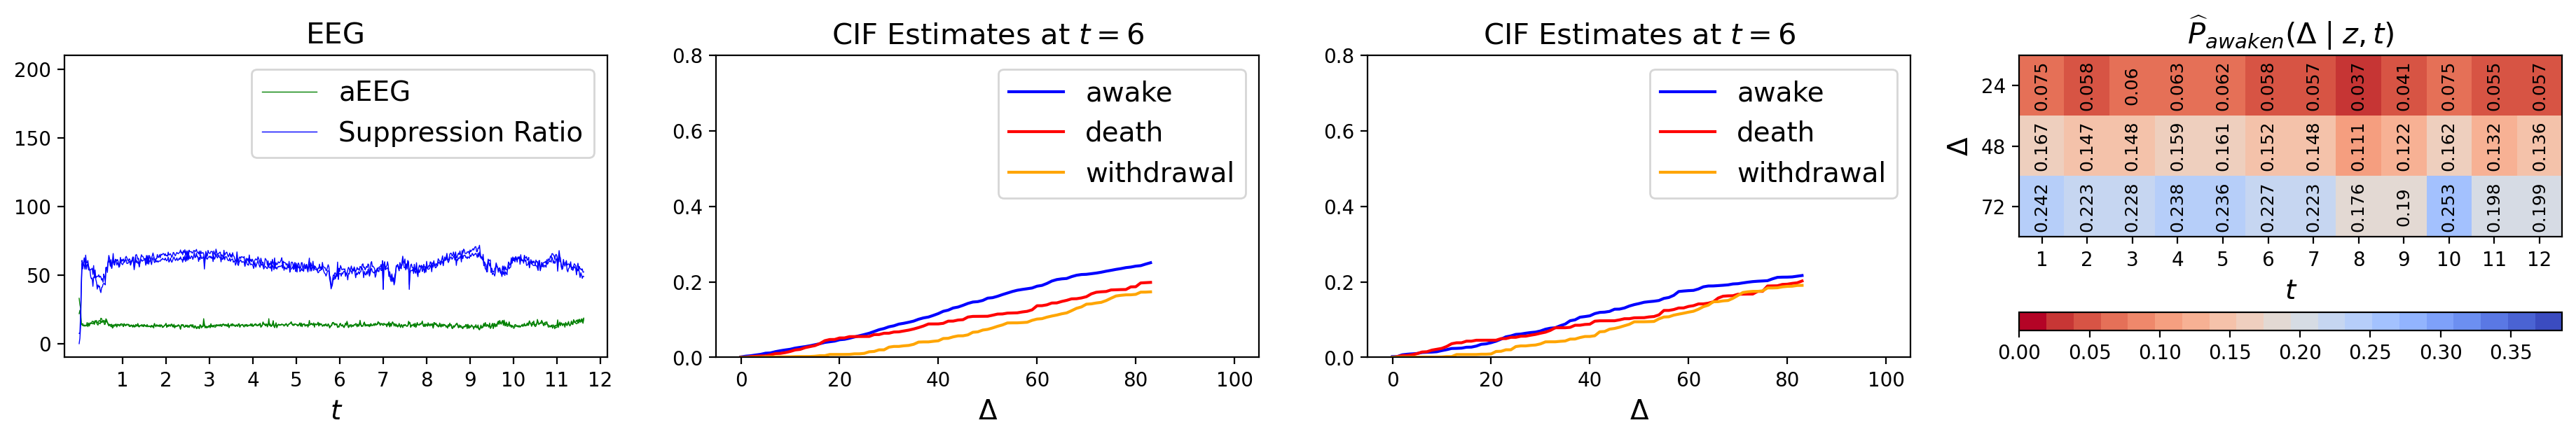

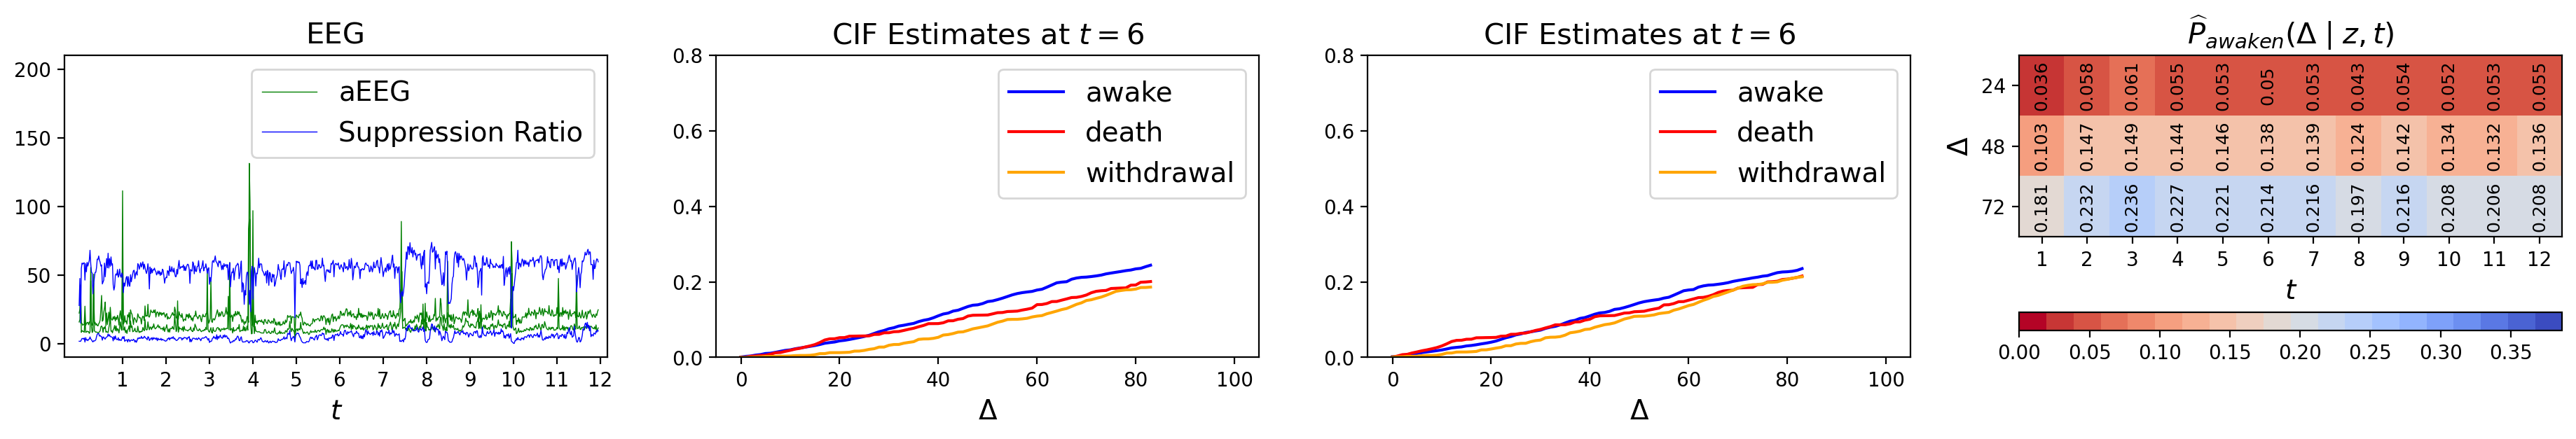

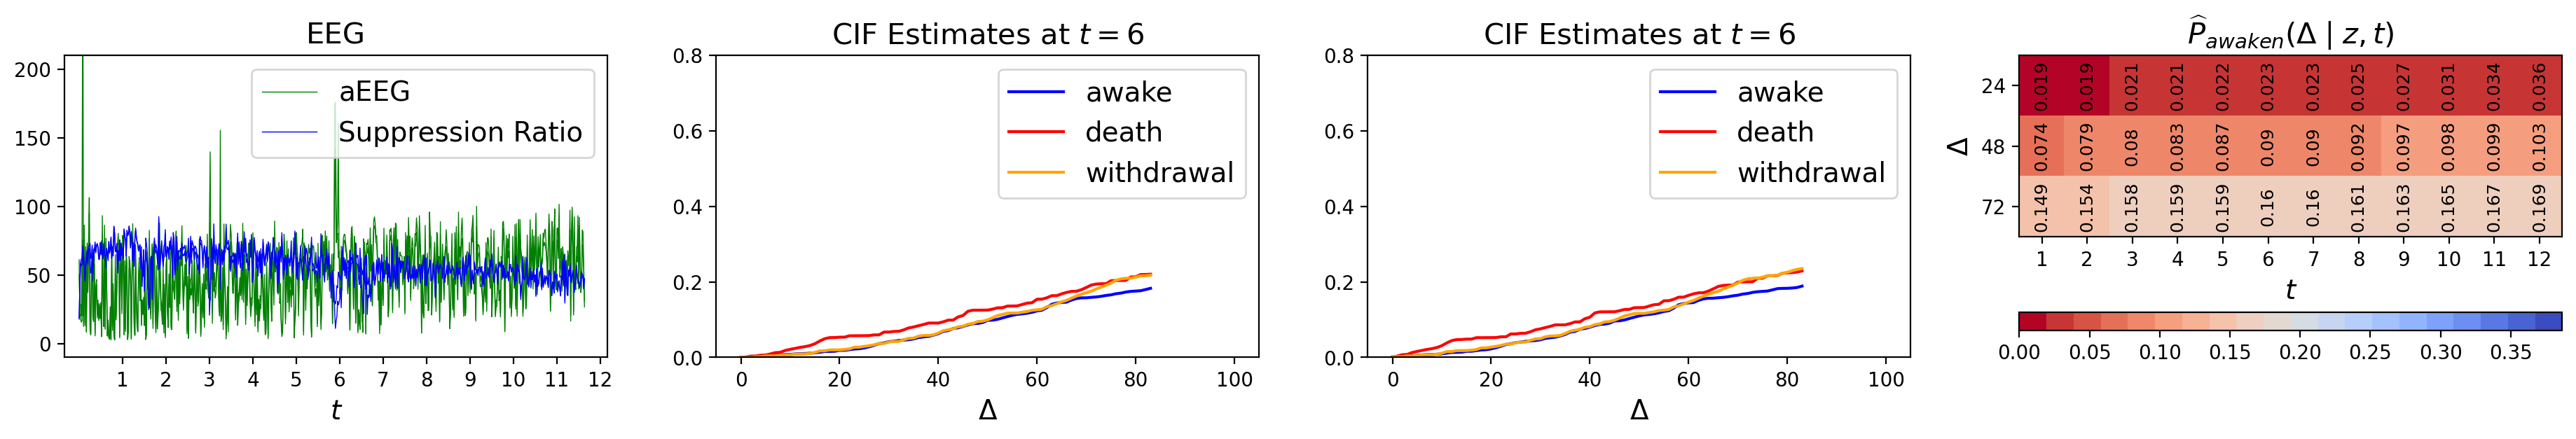

In [35]:
import matplotlib.pyplot as plt
plt.style.use('default')
%config InlineBackend.figure_format = 'retina'

pred_time = list(range(1,13))
eval_time = list(range(0,84))
risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device)
d = {0: 'censor', 1: 'death', 2: 'awake', 3: 'withdrawal'}

linewidth = 0.5
title_fontsize = 15
label_fontsize = 14

for ii, i in enumerate([50,135,141]): # example error
    print('patient', i, 'time:', te_time[i][0], 'label:', te_label[i][0], d[te_label[i][0]])
    # print('rmean event time (hr) - death: {:.1f}, awake: {:.1f}, withdrawal: {:.1f}'.format(
    #                     rmean_surv_time_death[i], rmean_surv_time_awake[i], rmean_surv_time_withdraw[i]))
    fig = plt.figure(figsize=(23,2.8))
    
    ax = fig.add_subplot(141)
    curr_X = te_all_eeg[i]
    plt.ylim(-10,210)
    plt.xlim(-20, 730)
    # dim = np.arange(1,13,1)
    # plt.xticks(np.arange(len(dim)), np.arange(1,len(dim)+1))
    plt.plot(curr_X[:, 4], c='green', linewidth=linewidth, label='aEEG') ## left aEEG median 
    plt.plot(curr_X[:, 9], c='green', linewidth=linewidth) ## right aEEG median
    plt.plot(curr_X[:, 0], c='blue', linewidth=linewidth, label='Suppression Ratio') ## left Suppression Ratio
    plt.plot(curr_X[:, 1], c='blue', linewidth=linewidth) ## left Suppression Ratio
    plt.xlabel(r'$t$', fontsize=label_fontsize)
    plt.legend(fontsize=label_fontsize)
    plt.title('EEG', fontsize=title_fontsize)
    plt.xticks(np.arange(60, 721, 60), list(range(1,13)))
    
    ax = fig.add_subplot(142)
    # plt.figure(figsize=(4,2))
    event = 2
    plt.plot(list(range(84)), risk_all[event-1][i][6], c='blue', label=d[event]) #plt.plot(list(range(6, 6+84)), risk_all[event-1][i][6], c='blue', label=d[event])
    event = 1
    plt.plot(list(range(84)), risk_all[event-1][i][6], c='red', label=d[event])
    event = 3
    plt.plot(list(range(84)), risk_all[event-1][i][6], c='orange', label=d[event])
    plt.legend(fontsize=label_fontsize)
    plt.ylim(0,0.8)
    plt.xlim(-5, 105)
    plt.xlabel(r'$\Delta$', fontsize=label_fontsize)
    plt.title(r'CIF Estimates at $t=6$', fontsize=title_fontsize)
    #plt.show()
    
    ax = fig.add_subplot(143)
    # plt.figure(figsize=(4,2))
    event = 2
    plt.plot(list(range(84)), risk_all[event-1][i][-1], c='blue', label=d[event]) #plt.plot(list(range(12, 96)), risk_all[event-1][i][-1], c='blue', label=d[event])
    event = 1
    plt.plot(list(range(84)), risk_all[event-1][i][-1], c='red', label=d[event])
    event = 3
    plt.plot(list(range(84)), risk_all[event-1][i][-1], c='orange', label=d[event])
    plt.legend(fontsize=label_fontsize)
    plt.ylim(0,0.8)
    plt.xlim(-5, 105)
    plt.xlabel('$\Delta$', fontsize=label_fontsize)
    plt.title('CIF Estimates at $t=6$', fontsize=title_fontsize)
    
    
    
    ax = fig.add_subplot(144)
    im = ax.imshow(prob_awake_all[i].T, cmap=cmap_awake, norm=norm_awake, aspect='auto')
    # Add color bar
    cbar = ax.figure.colorbar(im, ax=ax,orientation = 'horizontal', pad=0.25, aspect=30)
    for j in range(prob_awake_all[i].shape[0]): #12
        for k in range(prob_awake_all[i].shape[1]): #3
            text = ax.text(j, k, round(prob_awake_all[i][j,k], 3), ha='center', va='center', color='black', fontsize=9, rotation='vertical')
    # cbar.ax.set_ylabel('Value', rotation=-90, va="bottom")
    plt.title(r'$\widehat{P}_{awaken}(\Delta \mid z, t)$', fontsize=title_fontsize)
    plt.yticks(np.arange(3), [ 24, 48, 72])
    plt.xticks(np.arange(12), list(range(1,13)))
    plt.ylabel(r'$\Delta$', fontsize=label_fontsize)
    plt.xlabel(r'$t$', fontsize=label_fontsize)
    
    
    
    
    fname = 'ddh_1234_test_visual_new/patient{:}-time_{:}-label_{:}_{:}.pdf'.\
                        format(i, te_time[i][0], te_label[i][0], d[te_label[i][0]] )
    fname = 'ddh_1234_test_visual_new/error-p{}-visual.pdf'.format(ii+1)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
    # break

In [737]:
!zip -r ddh_1234_test_visual.zip ddh_1234_test_visual_new/

  adding: ddh_1234_test_visual_new/ (stored 0%)
  adding: ddh_1234_test_visual_new/patient98-time_111.0-label_1.0_death.pdf (deflated 17%)
  adding: ddh_1234_test_visual_new/patient124-time_88.0-label_3.0_withdrawal.pdf (deflated 19%)
  adding: ddh_1234_test_visual_new/patient118-time_118.0-label_3.0_withdrawal.pdf (deflated 17%)
  adding: ddh_1234_test_visual_new/patient71-time_119.0-label_3.0_withdrawal.pdf (deflated 16%)
  adding: ddh_1234_test_visual_new/patient57-time_29.0-label_1.0_death.pdf (deflated 16%)
  adding: ddh_1234_test_visual_new/patient93-time_39.0-label_2.0_awake.pdf (deflated 17%)
  adding: ddh_1234_test_visual_new/patient108-time_42.0-label_3.0_withdrawal.pdf (deflated 18%)
  adding: ddh_1234_test_visual_new/patient172-time_35.0-label_3.0_withdrawal.pdf (deflated 16%)
  adding: ddh_1234_test_visual_new/patient30-time_21.0-label_2.0_awake.pdf (deflated 18%)
  adding: ddh_1234_test_visual_new/patient114-time_26.0-label_3.0_withdrawal.pdf (deflated 17%)
  adding: ddh_

In [430]:
!zip -r ddh_1234_test_visual.zip ddh_1234_test_visual/

  adding: ddh_1234_test_visual/ (stored 0%)
  adding: ddh_1234_test_visual/patient160-time_119.0-label_2.0_awake.png (deflated 7%)
  adding: ddh_1234_test_visual/patient41-time_119.0-label_3.0_withdrawal.png (deflated 6%)
  adding: ddh_1234_test_visual/patient3-time_28.0-label_3.0_withdrawal.png (deflated 7%)
  adding: ddh_1234_test_visual/patient13-time_115.0-label_3.0_withdrawal.png (deflated 6%)
  adding: ddh_1234_test_visual/patient169-time_45.0-label_1.0_death.png (deflated 6%)
  adding: ddh_1234_test_visual/patient44-time_35.0-label_2.0_awake.png (deflated 7%)
  adding: ddh_1234_test_visual/patient163-time_43.0-label_2.0_awake.png (deflated 7%)
  adding: ddh_1234_test_visual/patient5-time_119.0-label_3.0_withdrawal.png (deflated 7%)
  adding: ddh_1234_test_visual/patient53-time_117.0-label_3.0_withdrawal.png (deflated 6%)
  adding: ddh_1234_test_visual/patient144-time_104.0-label_2.0_awake.png (deflated 7%)
  adding: ddh_1234_test_visual/patient38-time_110.0-label_3.0_withdrawal.

### Prob. of awake - potential outcome, alpha

In [36]:
pred_time = list(range(1,13))
eval_time = [24, 48, 72, 9999]
alpha_list = [0, 0.25, 0.5, 0.75, 1]

prob_awake_all_list = []

for a, alpha in enumerate(alpha_list):

    prob_awake_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))
    prob_death_all = np.ones((te_data.shape[0], len(pred_time), len(eval_time)))

    for p, p_time in enumerate(pred_time):
        pred_horizon = int(p_time)
        out = _f_get_pred(model, te_data, p_time, device)
        out = out[:, :, pred_horizon:] / out[:, :, pred_horizon:].sum((1,2)).reshape(-1,1,1)

        ## Delta = 24, 48, 72
        for t, t_time in enumerate(eval_time[:3]):
            eval_horizon = int(t_time)
            risk_awake = out[:, 1, :eval_horizon].sum(1)
            # risk_death = out[:, 0, :eval_horizon].sum(1)
            risk_withdraw = out[:, 2, :eval_horizon].sum(1)

            prob_awake_potential = risk_withdraw * alpha + risk_awake
            # prob_death_potential = risk_withdraw * (1-alpha) + risk_death

            prob_awake_all[:, p, t] = prob_awake_potential
            # prob_death_all[:, p, t] = prob_death_potential

        ## Delta = infinity, i.e. all future
        risk_awake = out[:, 1, :].sum(1)
        # risk_death = out[:, 0, :].sum(1)
        risk_withdraw = out[:, 2, :].sum(1)

        prob_awake_potential = risk_withdraw * alpha + risk_awake
        # prob_death_potential = risk_withdraw * (1-alpha) + risk_death

        prob_awake_all[:, p, -1] = prob_awake_potential
        # prob_death_all[:, p, -1] = prob_death_potential

    prob_awake_all_list.append(prob_awake_all)

patient 173 time: 114.0 label: 1.0 death
patient 74 time: 106.0 label: 2.0 awake
patient 33 time: 46.0 label: 2.0 awake
patient 45 time: 95.0 label: 3.0 withdrawal
patient 177 time: 101.0 label: 1.0 death


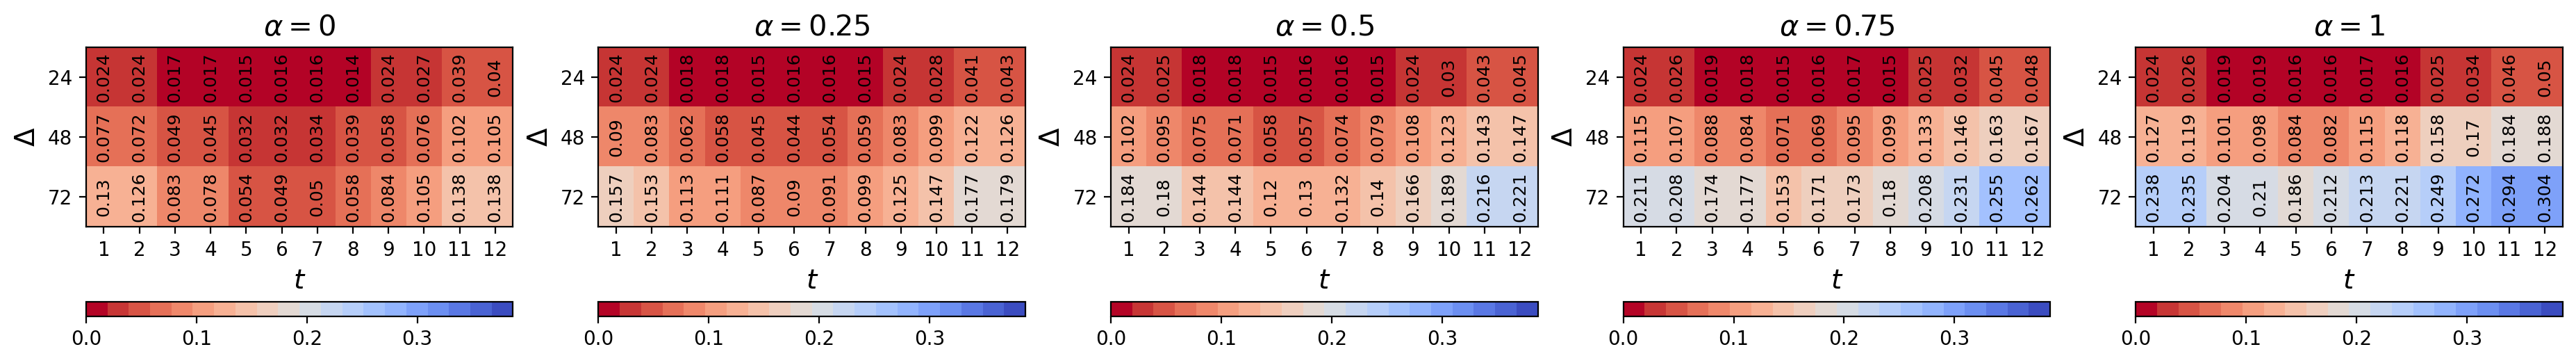

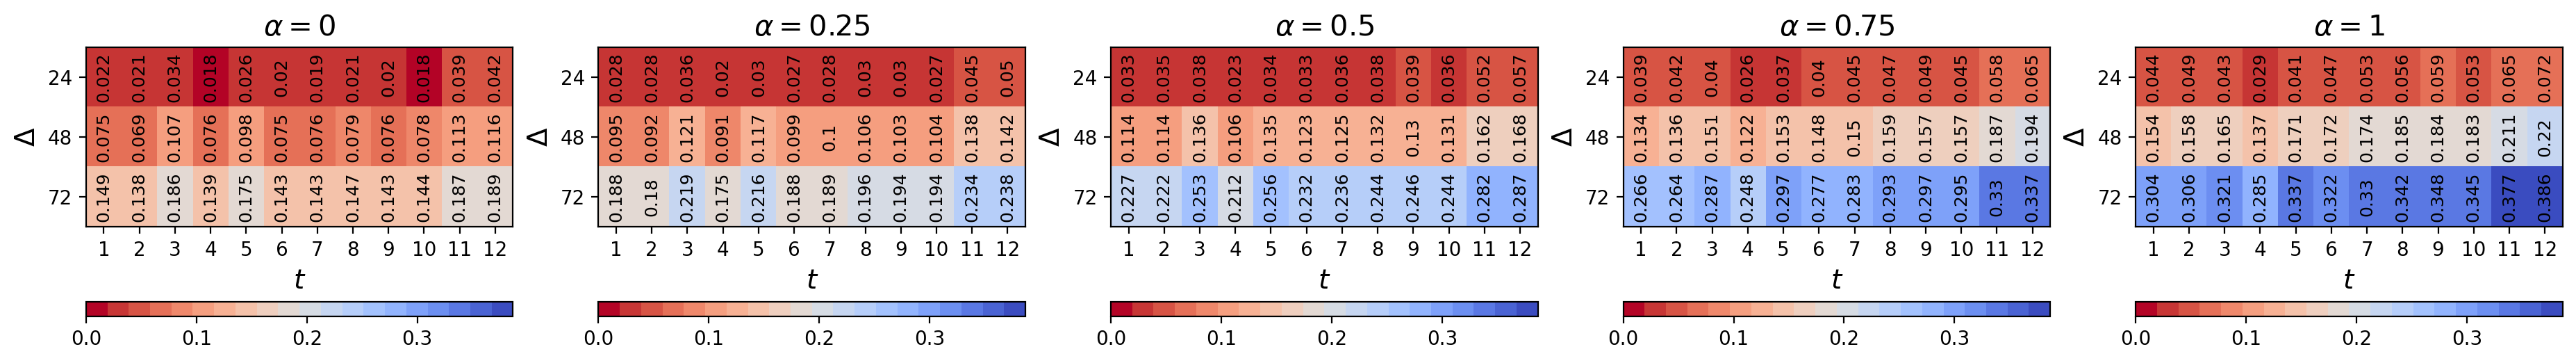

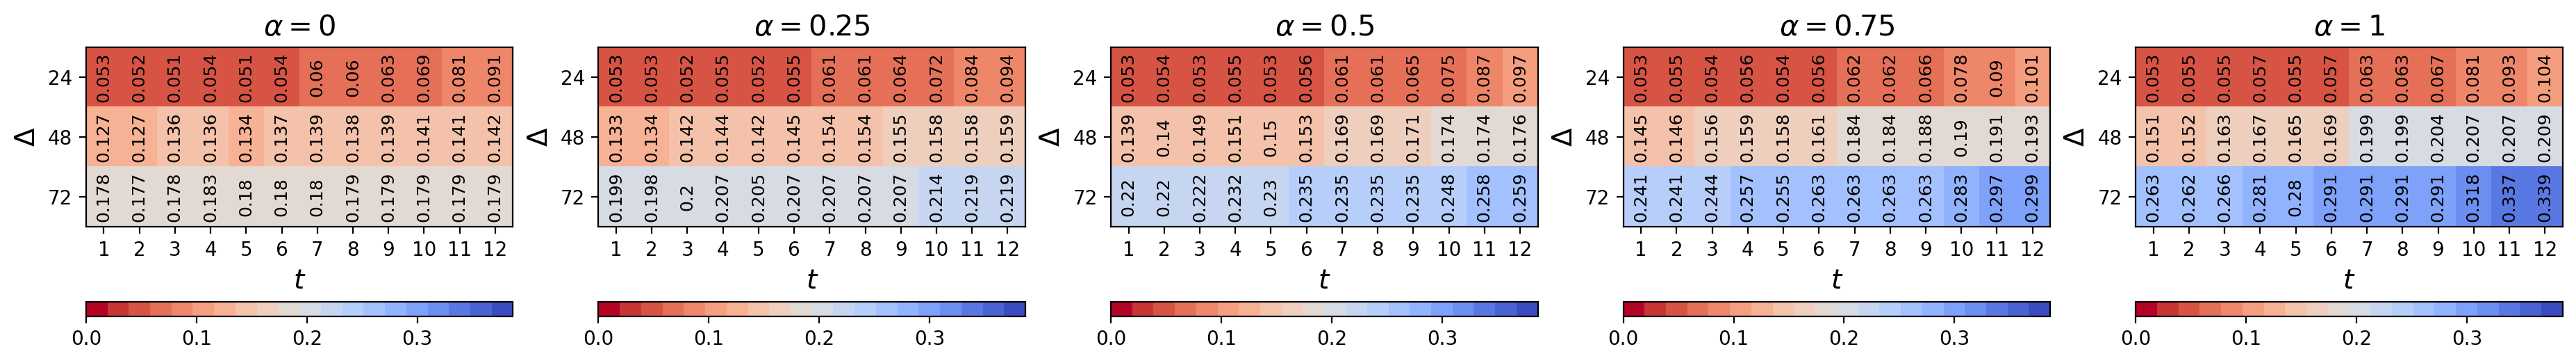

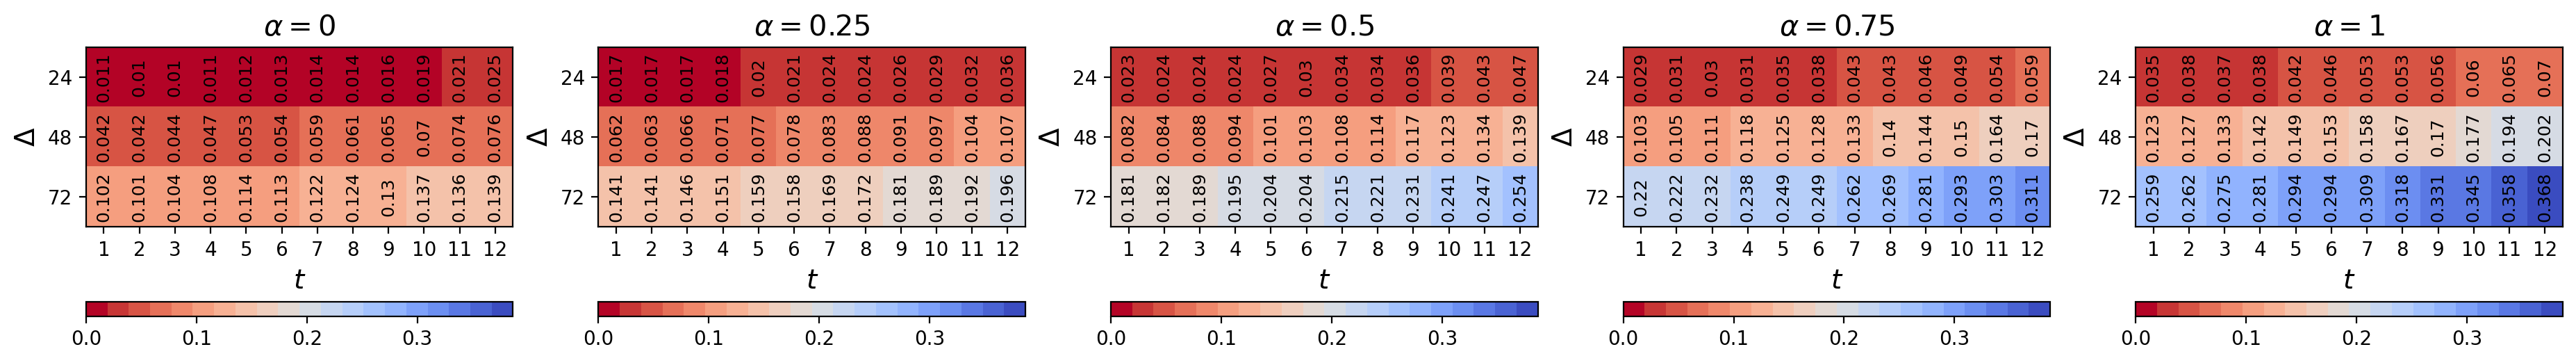

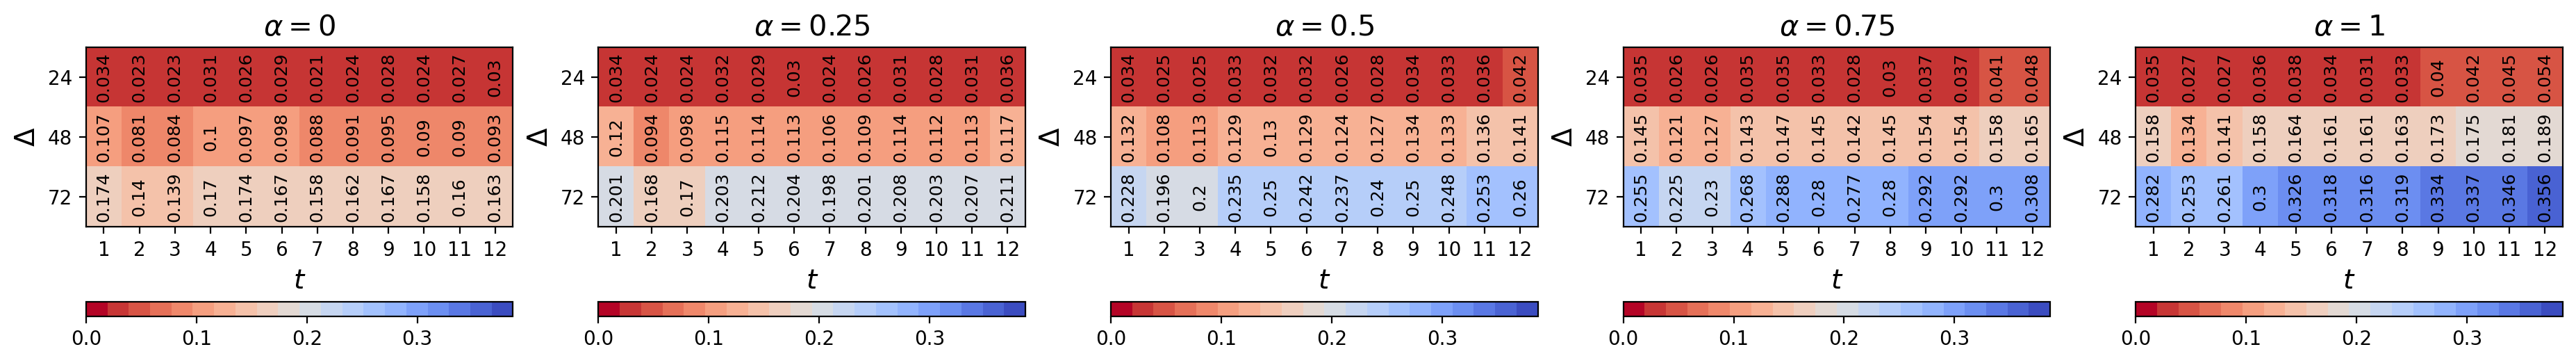

In [37]:
import matplotlib.pyplot as plt
plt.style.use('default')
%config InlineBackend.figure_format = 'retina'

pred_time = list(range(1,13))
eval_time = list(range(0,84))
risk_all = f_get_risk_predictions(model, te_data, pred_time, eval_time, device)
d = {0: 'censor', 1: 'death', 2: 'awake', 3: 'withdrawal'}

linewidth = 0.5
title_fontsize = 15
label_fontsize = 14

for ii, i in enumerate([173, 74, 33, 45, 177]): #list(range(185)): #[173, 74, 33, 45, 177]
    print('patient', i, 'time:', te_time[i][0], 'label:', te_label[i][0], d[te_label[i][0]])
    # print('rmean event time (hr) - death: {:.1f}, awake: {:.1f}, withdrawal: {:.1f}'.format(
    #                     rmean_surv_time_death[i], rmean_surv_time_awake[i], rmean_surv_time_withdraw[i]))
    fig = plt.figure(figsize=(23,2.8))
    
    for a, alpha in enumerate(alpha_list):
    
        ax = fig.add_subplot(1, 5, a+1)
        prob_awake_all = prob_awake_all_list[a]
        im = ax.imshow(prob_awake_all[i][:, :3].T, cmap=cmap_awake, norm=norm_awake, aspect='auto')
        # Add color bar
        cbar = ax.figure.colorbar(im, ax=ax,orientation = 'horizontal', pad=0.25, aspect=30)
        for j in range(prob_awake_all[i].shape[0]): #12
            for k in range(prob_awake_all[i].shape[1]-1): #3
                text = ax.text(j, k, round(prob_awake_all[i][j,k], 3), ha='center', va='center', color='black', fontsize=9, rotation='vertical')
        # cbar.ax.set_ylabel('Value', rotation=-90, va="bottom")
        plt.title(r'$\widehat{P}_{awaken}(\Delta \mid z, t), \alpha=$'+str(alpha), fontsize=title_fontsize)
        plt.title(r'$\alpha=$'+str(alpha), fontsize=title_fontsize)
        # plt.title(r'$\widehat{P}_{\text{awaken}}(\Delta \mid z, t)$', fontsize=title_fontsize)

        plt.yticks(np.arange(3), [ 24, 48, 72])
        plt.xticks(np.arange(12), list(range(1,13)))
        plt.ylabel(r'$\Delta$', fontsize=label_fontsize)
        plt.xlabel(r'$t$', fontsize=label_fontsize)

    
    fname = 'ddh_1234_test_visual_new/patient{:}-time_{:}-label_{:}_{:}.pdf'.\
                        format(i, te_time[i][0], te_label[i][0], d[te_label[i][0]] )
    fname = 'ddh_1234_test_visual_new/p{}-visual3.pdf'.format(ii+1)
    plt.savefig(fname, dpi=200, format='pdf', bbox_inches='tight')
    # plt.show()
    # break